<a href="https://colab.research.google.com/github/yusufsakirr1/diabetic_retinopati_deeplearning/blob/main/diabetic_retinopati_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Hücre 1: %80+ ACCURACY HEDEFİ İÇİN OPTİMİZE PARAMETRELERİ
import os
import torch

# İşlenmiş görüntülerin bulunduğu klasör
processed_images_dir = "/content/drive/MyDrive/Colab Notebooks/processed_images_output"

# Etiketleri içeren CSV dosyasının yolu
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/dataset/trainLabels_cropped.csv'

# Görüntülerin uzantısı (debug sonucundan .jpg olduğunu biliyoruz)
image_extension = ".jpg"

# %80+ ACCURACY İÇİN OPTİMİZE AYARLAR
target_samples_per_class = 4000  # ARTIRILD (2500→4000) - Daha fazla veri
min_samples_per_class = 2000     # Minimum örnekleme

# CSV dosyasındaki sütun adları
image_id_column = "image"
label_column = "level"

# Görüntü boyutu
IMAGE_SIZE = 224

# %80+ ACCURACY veri ayırma oranları
train_split = 0.75   # ARTIRILD (%70→%75) - Daha fazla eğitim verisi
val_split = 0.15     # Azaltıldı (%20→%15)
test_split = 0.10    # Aynı

# %80+ ACCURACY dengeleme ayarları
use_oversampling = True
use_class_weights = True
use_advanced_augmentation = True  # YENİ: Gelişmiş augmentation

# %80+ ACCURACY eğitim hiperparametreleri
BATCH_SIZE = 64              # Optimize boyut
LEARNING_RATE = 3e-4         # ARTIRILD (1e-4→3e-4) - Daha hızlı öğrenme
WEIGHT_DECAY = 1e-4          # L2 regularization
DROPOUT_RATE = 0.4           # Orta seviye regularization

# %80+ ACCURACY eğitim epoch ayarları
EPOCHS = 40                  # ARTIRILD (25→40) - Daha uzun eğitim
EARLY_STOPPING_PATIENCE = 12 # ARTIRILD (10→12) - Daha sabırlı
MIN_EPOCHS = 8               # ARTIRILD (5→8)
WARMUP_EPOCHS = 4            # ARTIRILD (3→4)

# GPU optimizasyon ayarları
num_workers = 8              # ARTIRILD (6→8) - Daha hızlı veri yükleme
pin_memory = True
persistent_workers = True

# %80+ ACCURACY class ağırlıkları (optimize)
CLASS_WEIGHTS = {
    0: 0.3,   # En çok veri var, ağırlık düşük
    1: 5.0,   # En az veri var, ağırlık çok yüksek
    2: 1.0,   # Orta veri, orta ağırlık
    3: 3.5,   # Az veri, yüksek ağırlık
    4: 2.5    # Az veri, yüksek ağırlık
}

# Device ayarı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 5

print("🎯 %80+ ACCURACY HEDEFİ PARAMETRELERİ:")
print("=" * 50)
print(f"Batch Size: {BATCH_SIZE}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Weight Decay: {WEIGHT_DECAY}")
print(f"Dropout Rate: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")
print(f"Target Samples/Class: {target_samples_per_class}")
print(f"Advanced Augmentation: {use_advanced_augmentation}")
print("=" * 50)

🎯 %80+ ACCURACY HEDEFİ PARAMETRELERİ:
Batch Size: 64
Learning Rate: 0.0003
Weight Decay: 0.0001
Dropout Rate: 0.4
Epochs: 40
Early Stopping Patience: 12
Target Samples/Class: 4000
Advanced Augmentation: True


In [ ]:
# Hücre 2: RetinaImageProcessor Sınıfı - Diyabetik Retinopati İçin Özelleştirilmiş
import os
import cv2
import numpy as np
from tqdm import tqdm
import glob
import traceback

class RetinaImageProcessor:
    """
    Diyabetik retinopati görüntülerini işleyen ve önişleyen sınıf.
    Retina görüntüleri için özel optimizasyonlar içerir.
    """
    def __init__(self, input_dir, output_dir, image_size=(224, 224)):
        """
        Args:
            input_dir (str): Ham görüntülerin bulunduğu klasör
            output_dir (str): İşlenmiş görüntülerin kaydedileceği klasör
            image_size (tuple): Hedef görüntü boyutu (width, height)
        """
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.image_size = image_size

        # Çıktı klasörünü oluştur
        os.makedirs(self.output_dir, exist_ok=True)
        print(f"✅ RetinaImageProcessor başlatıldı:")
        print(f"   📁 Giriş: {self.input_dir}")
        print(f"   📁 Çıkış: {self.output_dir}")
        print(f"   📐 Boyut: {self.image_size}")

    def crop_circle_region(self, image):
        """
        Retina görüntüsünden dairesel bölgeyi çıkarır (fundus görüntüleri için kritik)
        """
        height, width = image.shape[:2]

        # Merkez nokta
        center_x, center_y = width // 2, height // 2

        # Yarıçap (görüntünün en küçük boyutunun %45'i güvenli)
        radius = min(width, height) // 2 - 10

        # Dairesel maske oluştur
        mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(mask, (center_x, center_y), radius, 255, -1)

        # Maskeyi uygula
        if len(image.shape) == 3:  # Renkli görüntü
            mask_3d = cv2.merge([mask, mask, mask])
            masked_image = cv2.bitwise_and(image, mask_3d)
        else:  # Gri tonlama
            masked_image = cv2.bitwise_and(image, image, mask=mask)

        return masked_image

    def enhance_contrast_clahe(self, image):
        """
        CLAHE (Contrast Limited Adaptive Histogram Equalization) uygular
        Retina görüntülerinde detayları öne çıkarmak için kritik
        """
        if len(image.shape) == 3:  # Renkli görüntü
            # LAB renk uzayına çevir
            lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
            l_channel, a, b = cv2.split(lab)

            # CLAHE'yi sadece L kanalına uygula
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced_l = clahe.apply(l_channel)

            # Kanalları birleştir
            enhanced_lab = cv2.merge([enhanced_l, a, b])
            enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
        else:  # Gri tonlama
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
            enhanced_image = clahe.apply(image)

        return enhanced_image

    def remove_noise(self, image):
        """
        Görüntü gürültüsünü azaltır
        """
        if len(image.shape) == 3:  # Renkli
            # Non-local means denoising
            denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        else:  # Gri tonlama
            denoised = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

        return denoised

    def normalize_illumination(self, image):
        """
        Aydınlatma normalizasyonu - retina görüntülerinde kritik
        """
        if len(image.shape) == 3:
            # Her kanal için ayrı ayrı normalizasyon
            normalized = np.zeros_like(image)
            for i in range(3):
                channel = image[:, :, i].astype(np.float32)

                # Gaussian blur ile arka plan tahmini
                background = cv2.GaussianBlur(channel, (0, 0), sigmaX=30, sigmaY=30)

                # Normalizasyon
                normalized_channel = channel - background + 128
                normalized_channel = np.clip(normalized_channel, 0, 255)
                normalized[:, :, i] = normalized_channel.astype(np.uint8)
        else:
            channel = image.astype(np.float32)
            background = cv2.GaussianBlur(channel, (0, 0), sigmaX=30, sigmaY=30)
            normalized = channel - background + 128
            normalized = np.clip(normalized, 0, 255).astype(np.uint8)

        return normalized

    def preprocess_image(self, image_path, output_path=None):
        """
        Tek bir görüntüyü tam işleme sürecinden geçirir
        """
        try:
            # Görüntüyü güvenli şekilde oku
            with open(image_path, 'rb') as f:
                img_data = np.asarray(bytearray(f.read()), dtype=np.uint8)
                image = cv2.imdecode(img_data, cv2.IMREAD_COLOR)

            if image is None:
                print(f"⚠️  Görüntü okunamadı: {image_path}")
                return False

            # Orijinal boyutları kaydet
            original_height, original_width = image.shape[:2]

            # 1. Boyut kontrolü ve ön yeniden boyutlandırma
            if min(original_width, original_height) < 224:
                # Çok küçük görüntüleri büyüt
                scale_factor = 224 / min(original_width, original_height)
                new_width = int(original_width * scale_factor)
                new_height = int(original_height * scale_factor)
                image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

            # 2. Aydınlatma normalizasyonu
            image = self.normalize_illumination(image)

            # 3. Dairesel bölge çıkarma (fundus için kritik)
            image = self.crop_circle_region(image)

            # 4. Kontrast iyileştirme
            image = self.enhance_contrast_clahe(image)

            # 5. Gürültü azaltma
            image = self.remove_noise(image)

            # 6. Final boyutlandırma
            final_image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_AREA)

            # 7. Kaydetme
            if output_path:
                os.makedirs(os.path.dirname(output_path), exist_ok=True)

                # Dosya uzantısını kontrol et ve ayarla
                file_extension = os.path.splitext(output_path)[1].lower()
                if not file_extension:
                    file_extension = ".jpg"
                    output_path += file_extension

                # Görüntüyü kaydet
                is_success = cv2.imwrite(output_path, final_image)
                if not is_success:
                    print(f"⚠️  Kaydetme başarısız: {output_path}")
                    return False

            return True

        except Exception as e:
            print(f"❌ İşleme hatası ({os.path.basename(image_path)}): {str(e)}")
            return False

    def process_batch(self, limit=None, debug_skip_logic=False):
        """
        Klasördeki tüm görüntüleri toplu olarak işler

        Args:
            limit (int): İşlenecek maksimum dosya sayısı (None = tümü)
            debug_skip_logic (bool): Detaylı debug çıktısı ver

        Returns:
            tuple: (başarılı_işlenen_sayısı, atlanan_sayısı)
        """
        # Desteklenen dosya formatları
        patterns = ["*.jpeg", "*.jpg", "*.png", "*.tiff", "*.tif"]
        file_list = []

        print(f"🔍 Görüntü dosyaları aranıyor: {self.input_dir}")

        # Tüm desteklenen formatları topla
        for pattern in patterns:
            file_list.extend(glob.glob(os.path.join(self.input_dir, pattern)))
            file_list.extend(glob.glob(os.path.join(self.input_dir, pattern.upper())))

        # Tekrar eden dosyaları temizle ve sırala
        file_list = sorted(list(set(file_list)))
        total_files_found = len(file_list)

        if total_files_found == 0:
            print(f"❌ İşlenecek görüntü bulunamadı!")
            print(f"   Aranan formatlar: {', '.join(patterns)}")
            print(f"   Kontrol edilen klasör: {self.input_dir}")
            return 0, 0

        print(f"📊 Toplam {total_files_found} görüntü dosyası bulundu")

        # Limit uygula
        if limit is not None and limit > 0 and limit < total_files_found:
            file_list = file_list[:limit]
            print(f"⚙️  İşlem {limit} dosya ile sınırlandırıldı")

        files_to_process = file_list
        success_count = 0
        skipped_count = 0

        # İşleme döngüsü
        print(f"\n🚀 İşleme başlıyor...")
        if debug_skip_logic:
            print("🐛 DEBUG MODU AKTİF - Detaylı çıktılar gösterilecek")

        with tqdm(files_to_process, desc="Görüntü işleme",
                  ncols=100, unit="dosya") as pbar:

            for img_path in pbar:
                # Dosya adlarını hazırla
                file_name_original = os.path.basename(img_path)
                base_name, _ = os.path.splitext(file_name_original)
                output_file_name = base_name + ".jpg"  # Standart format
                output_path = os.path.join(self.output_dir, output_file_name)

                if debug_skip_logic:
                    pbar.write(f"\n🔍 DEBUG - {file_name_original}:")
                    pbar.write(f"   📁 Giriş: {img_path}")
                    pbar.write(f"   📁 Çıkış: {output_path}")

                # Dosya var mı kontrol et
                file_exists = os.path.exists(output_path)

                if debug_skip_logic:
                    pbar.write(f"   ✅ Dosya var mı: {file_exists}")

                if file_exists and not debug_skip_logic:
                    # Dosya zaten var, atla
                    skipped_count += 1
                    pbar.set_postfix({"İşlenen": success_count, "Atlanan": skipped_count})
                    continue
                elif file_exists and debug_skip_logic:
                    pbar.write(f"   ⏭️  ATLANDI: Dosya zaten mevcut")
                    skipped_count += 1
                    continue

                # Görüntüyü işle
                if debug_skip_logic:
                    pbar.write(f"   🔄 İŞLENİYOR...")

                if self.preprocess_image(img_path, output_path):
                    success_count += 1
                    if debug_skip_logic:
                        pbar.write(f"   ✅ BAŞARILI")
                else:
                    if debug_skip_logic:
                        pbar.write(f"   ❌ BAŞARISIZ")

                # Progress bar güncelle
                pbar.set_postfix({
                    "İşlenen": success_count,
                    "Atlanan": skipped_count,
                    "Başarı": f"{success_count/(success_count+skipped_count)*100:.1f}%" if (success_count+skipped_count) > 0 else "0%"
                })

        # Sonuç raporu
        print(f"\n" + "="*60)
        print(f"✅ TOPLU İŞLEME TAMAMLANDI!")
        print(f"📊 SONUÇ ÖZETİ:")
        print(f"   🔢 Toplam bulunan dosya: {total_files_found}")
        print(f"   ✅ Başarıyla işlenen: {success_count}")
        print(f"   ⏭️  Atlanan dosya: {skipped_count}")
        print(f"   📈 Başarı oranı: {success_count/(success_count+skipped_count)*100:.1f}%" if (success_count+skipped_count) > 0 else "   📈 Başarı oranı: 0%")
        print(f"   📁 Çıkış klasörü: {self.output_dir}")

        return success_count, skipped_count

print("✅ RetinaImageProcessor sınıfı tanımlandı.")
print("🔧 Özellikler:")
print("   - Dairesel bölge çıkarma (fundus için)")
print("   - CLAHE kontrast iyileştirme")
print("   - Aydınlatma normalizasyonu")
print("   - Gürültü azaltma")
print("   - Otomatik boyutlandırma")
print("   - Toplu işleme desteği")

✅ RetinaImageProcessor sınıfı tanımlandı.
🔧 Özellikler:
   - Dairesel bölge çıkarma (fundus için)
   - CLAHE kontrast iyileştirme
   - Aydınlatma normalizasyonu
   - Gürültü azaltma
   - Otomatik boyutlandırma
   - Toplu işleme desteği


In [ ]:
# Hücre 3: Tüm Görüntüleri İşleme (Production Modu)
import os
import traceback

print("Diyabetik Retinopati Görüntü İşleme Uygulaması (PRODUCTION MODU)")
print("===================================================================")

# Giriş ve çıkış klasörleri (Hücre 1'deki global değişkenleri kullan)
input_directory = "/content/drive/MyDrive/Colab Notebooks/dataset/resized_train_cropped"
image_processor_output_directory = processed_images_dir  # Hücre 1'den geliyor
current_image_size_tuple = (IMAGE_SIZE, IMAGE_SIZE)

# PRODUCTION MODU: Tüm veriyi işle
process_limit = None  # Tüm dosyaları işle
force_reprocess = True  # Mevcut dosyaları da yeniden işle

print(f"Giriş Klasörü: {input_directory}")
print(f"Çıkış Klasörü: {image_processor_output_directory}")
print(f"Görüntü Boyutu: {current_image_size_tuple}")
print(f"İşlem Limiti: {'Yok (tüm dosyalar)' if process_limit is None else process_limit}")
print(f"Yeniden İşleme: {'Evet' if force_reprocess else 'Hayır'}")

# Klasörlerin var olduğunu kontrol et
if not os.path.exists(input_directory):
    print(f"❌ HATA: Giriş klasörü bulunamadı: {input_directory}")
    print("Lütfen klasör yolunu kontrol edin.")
else:
    # Giriş klasöründeki dosya sayısını kontrol et
    import glob
    all_files = glob.glob(os.path.join(input_directory, "*.jpg")) + \
                glob.glob(os.path.join(input_directory, "*.jpeg")) + \
                glob.glob(os.path.join(input_directory, "*.png"))

    print(f"📁 Giriş klasöründe {len(all_files)} adet görüntü dosyası bulundu.")

    if len(all_files) == 0:
        print("❌ HATA: Giriş klasöründe işlenecek görüntü bulunamadı!")
        print("Kontrol edilen uzantılar: .jpg, .jpeg, .png")
    else:
        try:
            # RetinaImageProcessor'ı başlat
            processor = RetinaImageProcessor(
                input_dir=input_directory,
                output_dir=image_processor_output_directory,
                image_size=current_image_size_tuple
            )

            print(f"\n🚀 İşlem başlatılıyor...")
            print(f"⚙️  Parametreler:")
            print(f"   - İşlenecek dosya sayısı: {len(all_files) if process_limit is None else min(process_limit, len(all_files))}")
            print(f"   - Yeniden işleme: {'Evet' if force_reprocess else 'Hayır'}")
            print(f"   - Debug modu: Kapalı")
            print("="*60)

            # Eğer yeniden işleme isteniyorsa çıkış klasörünü temizle
            if force_reprocess and os.path.exists(image_processor_output_directory):
                print("🧹 Çıkış klasörü temizleniyor (yeniden işleme için)...")
                import shutil

                # Klasör içeriğini sil ama klasörü kendisini silme
                for filename in os.listdir(image_processor_output_directory):
                    file_path = os.path.join(image_processor_output_directory, filename)
                    try:
                        if os.path.isfile(file_path) or os.path.islink(file_path):
                            os.unlink(file_path)
                        elif os.path.isdir(file_path):
                            shutil.rmtree(file_path)
                    except Exception as e:
                        print(f"   ⚠️ {file_path} silinemedi: {e}")

                print("✅ Çıkış klasörü temizlendi.")

            # Ana işleme fonksiyonu
            newly_processed_count, skipped_files_count = processor.process_batch(
                limit=process_limit,
                debug_skip_logic=False  # Debug modunu kapat
            )

            print(f"\n" + "="*60)
            print(f"✅ İŞLEM TAMAMLANDI!")
            print(f"📊 SONUÇLAR:")
            print(f"   - Yeni işlenen dosya sayısı: {newly_processed_count}")
            print(f"   - Atlanan dosya sayısı: {skipped_files_count}")
            print(f"   - Toplam işlem: {newly_processed_count + skipped_files_count}")
            print(f"   - Başarı oranı: {newly_processed_count/(newly_processed_count + skipped_files_count)*100:.1f}%"
                  if (newly_processed_count + skipped_files_count) > 0 else "   - Başarı oranı: 0%")

            # Çıkış klasörünü kontrol et
            if os.path.exists(image_processor_output_directory):
                output_files = glob.glob(os.path.join(image_processor_output_directory, "*.jpg")) + \
                              glob.glob(os.path.join(image_processor_output_directory, "*.jpeg")) + \
                              glob.glob(os.path.join(image_processor_output_directory, "*.png"))
                print(f"📁 Çıkış klasöründe şu an {len(output_files)} adet işlenmiş dosya bulunuyor.")

            # Başarılı işlem önerileri
            if newly_processed_count > 0:
                print(f"\n🎉 İşlem başarılı! Şimdi yapabilecekleriniz:")
                print(f"   1. Veri setini yükleyip model eğitimine başlayabilirsiniz")
                print(f"   2. İşlenmiş görüntüleri manuel olarak kontrol edebilirsiniz")
                print(f"   3. Hücre 6'ya geçerek veri setini analiz edebilirsiniz")
            elif skipped_files_count > 0:
                print(f"\n💡 Tüm dosyalar zaten işlenmiş. Eğer yeniden işlemek istiyorsanız:")
                print(f"   force_reprocess = True olarak ayarlayın ve kodu tekrar çalıştırın.")
            else:
                print(f"\n❌ Hiçbir dosya işlenemedi. Lütfen:")
                print(f"   1. Giriş klasörü yolunu kontrol edin")
                print(f"   2. Dosya izinlerini kontrol edin")
                print(f"   3. Görüntü dosyalarının geçerli olduğundan emin olun")

        except NameError as e:
            if 'RetinaImageProcessor' in str(e):
                print("\n❌ HATA: RetinaImageProcessor sınıfı tanımlanmamış.")
                print("🔧 ÇÖZÜM: Lütfen bu hücreden önce 'Hücre 2'yi çalıştırın.")
                print("   Hücre 2'de RetinaImageProcessor sınıfının tanımı bulunmaktadır.")
            else:
                print(f"❌ İsimlendirme hatası: {e}")
                print("🔧 ÇÖZÜM: Lütfen Hücre 1'i çalıştırarak gerekli değişkenleri tanımlayın.")

        except Exception as e:
            print(f"\n❌ Beklenmedik bir hata oluştu: {e}")
            print("🔍 Detaylı hata bilgisi:")
            traceback.print_exc()

            print(f"\n🔧 Olası çözümler:")
            print(f"   1. Drive bağlantısını kontrol edin")
            print(f"   2. Dosya yollarını tekrar kontrol edin")
            print(f"   3. Yeterli depolama alanınız olduğundan emin olun")
            print(f"   4. İnternet bağlantınızı kontrol edin")

print(f"\n" + "="*60)
print(f"ℹ️  NOT: Bu işlem tüm veri setinizi işleyecektir.")
print(f"   Büyük veri setleri için uzun sürebilir.")
print(f"   İşlem sırasında Colab session'ınızın aktif kalmasını sağlayın.")

In [ ]:
# Hücre 4: GPU Kontrolü (torch.set_default_tensor_type ile - Eski Yöntem)
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU ({torch.cuda.get_device_name(0)}) etkin ve kullanılıyor.")
    # PyTorch'un varsayılan olarak GPU'yu kullanmasını sağla (Eski yöntem, uyarı verebilir)
    # torch.set_default_tensor_type('torch.cuda.FloatTensor') # Float tensorler için
    # PyTorch 2.1 ve sonrası için bunun yerine torch.set_default_device ve torch.set_default_dtype önerilir.
    # Şimdilik sadece device değişkenini ayarlayalım, varsayılan atamayı diğer hücrede yapalım.
else:
    device = torch.device("cpu")
    print("GPU bulunamadı, CPU kullanılıyor.")
    print("Colab'da GPU'yu etkinleştirmek için: Çalışma Zamanı > Çalışma zamanı türünü değiştir > Donanım hızlandırıcı > GPU.")
    print("Eğer A100 seçmenize rağmen bu mesajı görüyorsanız, çalışma zamanını yeniden başlatmayı deneyin.")

print(f"Bu hücrede 'device' şuna ayarlandı: {device}")

GPU (NVIDIA A100-SXM4-40GB) etkin ve kullanılıyor.
Bu hücrede 'device' şuna ayarlandı: cuda


In [ ]:
    # Hücre 5: GPU Kontrolü ve Varsayılan Cihaz Ayarı (Önerilen Yöntem)
    import torch

    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU ({torch.cuda.get_device_name(0)}) etkin ve kullanılıyor.")
        # PyTorch'un yeni tensörler için varsayılan olarak GPU'yu kullanmasını sağla
        # torch.set_default_device(device) # <--- BU SATIRI YORUM SATIRI YAPIN
        # İsteğe bağlı: Varsayılan ondalık sayı (float) veri türünü de ayarlayabilirsiniz
        # torch.set_default_dtype(torch.float32) # Örneğin torch.float32 için
    else:
        device = torch.device("cpu")
        print("GPU bulunamadı, CPU kullanılıyor.")
        # CPU kullanılıyorsa da varsayılan cihaz olarak ayarlanabilir:
        # torch.set_default_device(device) # Genellikle CPU için bu satıra gerek yoktur.
        print("Colab'da GPU'yu etkinleştirmek için: Çalışma Zamanı > Çalışma zamanı türünü değiştir > Donanım hızlandırıcı > GPU.")
        print("Eğer A100 seçmenize rağmen bu mesajı görüyorsanız, çalışma zamanını yeniden başlatmayı ve GPU'nun seçili olduğundan emin olmayı deneyin.")

    # Kullanılacak cihazı teyit edelim:
    print(f"Bu hücrede 'device' şuna ayarlandı: {device}")
    # Varsayılan cihazı kontrol etme satırını da güncelleyelim, çünkü artık global olarak ayarlanmamış olabilir
    # print(f"PyTorch için varsayılan tensör cihazı: {torch.empty(0).device}") # Bu satır artık 'cpu' dönebilir, bu normaldir.

GPU (NVIDIA A100-SXM4-40GB) etkin ve kullanılıyor.
Bu hücrede 'device' şuna ayarlandı: cuda


In [ ]:
# Hücre 6: GÜNCELLENMIŞ VERİ YÜKLEME
import pandas as pd
import os
import glob

print("📋 VERİ YÜKLEME BAŞLIYOR:")
print(f"   CSV dosyası: {csv_file_path}")
print(f"   İşlenmiş görüntüler: {processed_images_dir}")
print(f"   Görüntü uzantısı: {image_extension}")

try:
    # UZANTI OTOMATIK TESPİTİ
    if os.path.exists(processed_images_dir):
        print(f"\n🔍 UZANTI OTOMATİK TESPİTİ:")

        extensions_to_check = ['.jpg', '.jpeg', '.png', '.tiff']
        extension_counts = {}

        for ext in extensions_to_check:
            files = glob.glob(os.path.join(processed_images_dir, f"*{ext}"))
            if len(files) > 0:
                extension_counts[ext] = len(files)
                print(f"   {ext}: {len(files)} dosya")

        if extension_counts:
            best_extension = max(extension_counts.items(), key=lambda x: x[1])
            detected_ext, count = best_extension

            if detected_ext != image_extension:
                print(f"\n🔧 UZANTI DÜZELTMESİ:")
                print(f"   Eski: {image_extension}")
                print(f"   Yeni: {detected_ext} ({count} dosya)")
                image_extension = detected_ext
                print(f"   ✅ image_extension '{image_extension}' güncellendi")
            else:
                print(f"   ✅ Uzantı doğru: {image_extension} ({count} dosya)")

    # CSV dosyasını yükle
    if os.path.exists(csv_file_path):
        print(f"\n📖 CSV dosyası yükleniyor...")
        labels_df = pd.read_csv(csv_file_path)
        print(f"✅ CSV başarıyla yüklendi: {len(labels_df)} kayıt")

        # Etiket dağılımını göster
        print(f"\n📊 ETİKET DAĞILIMI:")
        label_counts = labels_df[label_column].value_counts().sort_index()
        total_count = len(labels_df)

        for level, count in label_counts.items():
            percentage = (count / total_count) * 100
            print(f"   Seviye {level}: {count:,} örnek (%{percentage:.1f})")

        # Görüntü yollarını oluştur
        print(f"\n🔗 GÖRÜNTÜ-ETİKET EŞLEŞTİRME:")

        def create_image_path(row):
            image_name_base = str(row[image_id_column])
            if not image_name_base.endswith(image_extension):
                image_name_base = image_name_base.split('.')[0]
            return os.path.join(processed_images_dir, image_name_base + image_extension)

        labels_df['full_path'] = labels_df.apply(create_image_path, axis=1)
        labels_df['file_exists'] = labels_df['full_path'].apply(os.path.exists)

        # Sonuçları analiz et
        total_records = len(labels_df)
        existing_files = labels_df['file_exists'].sum()
        missing_files = total_records - existing_files

        print(f"\n📊 EŞLEŞTİRME SONUÇLARI:")
        print(f"   📋 Toplam CSV kaydı: {total_records:,}")
        print(f"   ✅ Eşleşen dosya: {existing_files:,} (%{existing_files/total_records*100:.1f})")
        print(f"   ❌ Eksik dosya: {missing_files:,} (%{missing_files/total_records*100:.1f})")

        if existing_files > 0:
            # Kullanılabilir veriyi filtrele
            available_data = labels_df[labels_df['file_exists']].reset_index(drop=True)

            print(f"\n📋 KULLANILABILIR VERİ:")
            print(f"   📊 Toplam: {len(available_data):,} örnek")

            # Kullanılabilir verinin sınıf dağılımı
            available_label_counts = available_data[label_column].value_counts().sort_index()
            print(f"\n📊 KULLANILABILIR VERİ SINIF DAĞILIMI:")
            for level, count in available_label_counts.items():
                percentage = (count / len(available_data)) * 100
                print(f"   Seviye {level}: {count:,} örnek (%{percentage:.1f})")

            # Global değişkenleri güncelle
            labels_df = available_data

            print(f"\n✅ VERİ SETİ YÜKLEME TAMAMLANDI!")
            print(f"📝 Hazırlanan veri: {len(available_data):,} kullanılabilir örnek")

            if len(available_data) >= 10000:
                print(f"\n🎯 %80+ ACCURACY HEDEFİ: Yeterli veri mevcut!")
            elif len(available_data) >= 5000:
                print(f"\n⚠️  Orta düzeyde veri - %70+ accuracy hedeflenebilir")
            else:
                print(f"\n❌ Az veri - performans sınırlı olabilir")
        else:
            raise ValueError("Hiçbir dosya eşleşmedi!")
    else:
        raise FileNotFoundError(f"CSV dosyası bulunamadı: {csv_file_path}")

except Exception as e:
    print(f"❌ HATA: {e}")
    raise

print(f"\n" + "="*60)
print(f"🎉 VERİ YÜKLEME BAŞARILI!")
print(f"📊 Kullanılabilir veri: {len(labels_df):,} örnek")
print(f"🎯 Uzantı: {image_extension}")
print(f"="*60)

📋 VERİ YÜKLEME BAŞLIYOR:
   CSV dosyası: /content/drive/MyDrive/Colab Notebooks/dataset/trainLabels_cropped.csv
   İşlenmiş görüntüler: /content/drive/MyDrive/Colab Notebooks/processed_images_output
   Görüntü uzantısı: .jpg

🔍 UZANTI OTOMATİK TESPİTİ:
   .jpg: 22198 dosya
   ✅ Uzantı doğru: .jpg (22198 dosya)

📖 CSV dosyası yükleniyor...
✅ CSV başarıyla yüklendi: 35108 kayıt

📊 ETİKET DAĞILIMI:
   Seviye 0: 25,802 örnek (%73.5)
   Seviye 1: 2,438 örnek (%6.9)
   Seviye 2: 5,288 örnek (%15.1)
   Seviye 3: 872 örnek (%2.5)
   Seviye 4: 708 örnek (%2.0)

🔗 GÖRÜNTÜ-ETİKET EŞLEŞTİRME:

📊 EŞLEŞTİRME SONUÇLARI:
   📋 Toplam CSV kaydı: 35,108
   ✅ Eşleşen dosya: 22,198 (%63.2)
   ❌ Eksik dosya: 12,910 (%36.8)

📋 KULLANILABILIR VERİ:
   📊 Toplam: 22,198 örnek

📊 KULLANILABILIR VERİ SINIF DAĞILIMI:
   Seviye 0: 16,347 örnek (%73.6)
   Seviye 1: 1,505 örnek (%6.8)
   Seviye 2: 3,332 örnek (%15.0)
   Seviye 3: 571 örnek (%2.6)
   Seviye 4: 443 örnek (%2.0)

✅ VERİ SETİ YÜKLEME TAMAMLANDI!
📝 Hazırl

In [ ]:
# Hücre 7: Veri Setini Ayırma

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

try:
    # Önceki hücreden DataFrame'in geldiğinden emin ol
    if 'labels_df' not in locals() or not isinstance(labels_df, pd.DataFrame):
        raise NameError("'labels_df' DataFrame'i bulunamadı. Lütfen Hücre 6'yı çalıştırın.")

    # Hücre 1'den split oranlarının geldiğini kontrol et (globals() kullanılıyor)
    if 'train_split' not in globals() or 'val_split' not in globals() or 'test_split' not in globals():
        print("UYARI: Hücre 1'de train_split, val_split, test_split tanımlanmamış. Varsayılan oranlar kullanılıyor (0.7, 0.15, 0.15).")
        train_split = 0.7
        val_split = 0.15
        test_split = 0.15

    # Oranların toplamının 1 olduğundan emin ol
    if not np.isclose(train_split + val_split + test_split, 1.0):
        raise ValueError(f"Split oranlarının toplamı 1 olmalı, ancak şu an: {train_split + val_split + test_split}")

    # Sütunların varlığını kontrol et (globals() kullanılıyor)
    required_columns_h7 = [image_id_column, label_column, 'full_path', 'file_exists']
    for col_h7 in required_columns_h7:
        if col_h7 not in labels_df.columns:
            raise KeyError(f"Hücre 7: '{col_h7}' sütunu 'labels_df' içinde bulunamadı.")

    labels_df_h7 = labels_df[labels_df['file_exists']].reset_index(drop=True) # Kullanılacak DF'ye farklı isim ver

    if labels_df_h7[image_id_column].duplicated().any():
        print(f"Hücre 7: Tekilleştirme öncesi etiket sayısı: {len(labels_df_h7)}")
        labels_df_h7 = labels_df_h7.drop_duplicates(subset=[image_id_column], keep='first').reset_index(drop=True)
        print(f"Hücre 7: Tekilleştirme sonrası etiket sayısı: {len(labels_df_h7)}")
    else:
        print(f"Hücre 7: Veri seti {len(labels_df_h7)} benzersiz görüntü içeriyor.")

    print("Hücre 7: Orijinal veri seti etiket dağılımı (ayırma öncesi):")
    original_counts_h7 = labels_df_h7[label_column].value_counts().sort_index()
    print(original_counts_h7)

    if len(labels_df_h7) == 0:
        raise ValueError("Hücre 7: İşlenecek hiç veri kalmadı (labels_df_h7 boş). Lütfen Hücre 6'yı kontrol edin.")

    min_samples_for_stratify_h7 = np.min(original_counts_h7) if not original_counts_h7.empty else 0
    can_stratify_h7 = min_samples_for_stratify_h7 >= 2

    stratify_param_h7 = labels_df_h7[label_column] if can_stratify_h7 else None
    if can_stratify_h7:
        print("Hücre 7: İlk ayırmada stratifikasyon uygulanacak.")
    else:
        print(f"Hücre 7: UYARI: İlk ayırmada stratifikasyon için yetersiz örnek. Rastgele bölme.")

    train_df, remaining_df = train_test_split(
        labels_df_h7,
        test_size=(val_split + test_split),
        random_state=42,
        stratify=stratify_param_h7
    )

    if remaining_df.empty:
        val_df = pd.DataFrame(columns=labels_df_h7.columns)
        test_df = pd.DataFrame(columns=labels_df_h7.columns)
        print("Hücre 7: UYARI: 'remaining_df' boş, doğrulama ve test setleri boş oluşturuldu.")
    else:
        stratify_param_remaining = None
        if can_stratify_h7:
             remaining_counts = remaining_df[label_column].value_counts()
             if not remaining_counts.empty and remaining_counts.min() >= 2:
                stratify_param_remaining = remaining_df[label_column]
                print("Hücre 7: İkinci ayırmada stratifikasyon uygulanacak.")
             else:
                print("Hücre 7: UYARI: 'remaining_df' için ikinci ayırmada stratifikasyon yapılamıyor.")

        val_df, test_df = train_test_split(
            remaining_df,
            test_size=test_split / (val_split + test_split) if (val_split + test_split) > 0 else 0.5,
            random_state=43,
            stratify=stratify_param_remaining
        )

    total_len_h7 = len(labels_df_h7) if len(labels_df_h7) > 0 else 1
    print(f"\nVeri seti ayırma işlemi tamamlandı (Hücre 7):")
    print(f"Eğitim Seti (train_df): {len(train_df)} örnek ({len(train_df)/total_len_h7*100:.1f}%)")
    print(f"Doğrulama Seti (val_df): {len(val_df)} örnek ({len(val_df)/total_len_h7*100:.1f}%)")
    print(f"Test Seti (test_df): {len(test_df)} örnek ({len(test_df)/total_len_h7*100:.1f}%)")

    print("\nBölme sonrası etiket dağılımları (Hücre 7):")
    print(f"Eğitim: \n{train_df[label_column].value_counts().sort_index() if not train_df.empty else 'Boş'}")
    print(f"Doğrulama: \n{val_df[label_column].value_counts().sort_index() if not val_df.empty else 'Boş'}")
    print(f"Test: \n{test_df[label_column].value_counts().sort_index() if not test_df.empty else 'Boş'}")

    train_ids = set(train_df[image_id_column])
    val_ids = set(val_df[image_id_column])
    test_ids = set(test_df[image_id_column])

    if train_ids.intersection(val_ids) or train_ids.intersection(test_ids) or val_ids.intersection(test_ids):
        print("\nKRİTİK HATA (Hücre 7): VERİ SIZINTISI TESPİT EDİLDİ!")
        raise ValueError("Veri setleri arasında kesişim var! Eğitim iptal edildi.")
    else:
        print("\nHücre 7: Veri setleri başarıyla ayrıldı, hiçbir kesişim yok.")

    train_df_original = train_df.copy() # Bu, Hücre 8'de kullanılacak
    print("\nHücre 7: Eğitim setinin bir kopyası ('train_df_original') dengeleme için oluşturuldu.")

except NameError as e_h7:
    print(f"HATA (Hücre 7 - NameError): {e_h7}")
    raise
except KeyError as e_h7:
    print(f"HATA (Hücre 7 - KeyError): {e_h7}")
    raise
except ValueError as e_h7:
    print(f"HATA (Hücre 7 - ValueError): {e_h7}")
    raise
except Exception as e_h7:
    print(f"HATA (Hücre 7 - Genel Hata): {e_h7}")
    raise

Hücre 7: Veri seti 22198 benzersiz görüntü içeriyor.
Hücre 7: Orijinal veri seti etiket dağılımı (ayırma öncesi):
level
0    16347
1     1505
2     3332
3      571
4      443
Name: count, dtype: int64
Hücre 7: İlk ayırmada stratifikasyon uygulanacak.
Hücre 7: İkinci ayırmada stratifikasyon uygulanacak.

Veri seti ayırma işlemi tamamlandı (Hücre 7):
Eğitim Seti (train_df): 16648 örnek (75.0%)
Doğrulama Seti (val_df): 3330 örnek (15.0%)
Test Seti (test_df): 2220 örnek (10.0%)

Bölme sonrası etiket dağılımları (Hücre 7):
Eğitim: 
level
0    12260
1     1129
2     2499
3      428
4      332
Name: count, dtype: int64
Doğrulama: 
level
0    2452
1     225
2     500
3      86
4      67
Name: count, dtype: int64
Test: 
level
0    1635
1     151
2     333
3      57
4      44
Name: count, dtype: int64

Hücre 7: Veri setleri başarıyla ayrıldı, hiçbir kesişim yok.

Hücre 7: Eğitim setinin bir kopyası ('train_df_original') dengeleme için oluşturuldu.


In [ ]:
# Hücre 8: Eğitim Veri Setini Dengeleme
import pandas as pd
from sklearn.utils import shuffle
import numpy as np

try:
    # Hücre 7'den 'train_df_original' gelmeli
    if 'train_df_original' not in locals() or not isinstance(train_df_original, pd.DataFrame):
        raise NameError("'train_df_original' DataFrame'i bulunamadı. Lütfen Hücre 7'yi doğru çalıştırdığınızdan emin olun.")

    # Hücre 1'den 'target_samples_per_class' ve 'use_oversampling' gelmeli (globals() kullanılıyor)
    if 'target_samples_per_class' not in globals():
        print("UYARI (Hücre 8): 'target_samples_per_class' tanımlı değil. Varsayılan 2500 kullanılacak.")
        target_samples_per_class = 2500
    if 'use_oversampling' not in globals():
        print("UYARI (Hücre 8): 'use_oversampling' tanımlı değil. Varsayılan False kullanılacak.")
        use_oversampling = False # Güvenlik için
    if 'label_column' not in globals() or 'image_id_column' not in globals():
         raise NameError("Hücre 8: 'label_column' veya 'image_id_column' globalde tanımlı değil.")


    print("\nHücre 8: Eğitim veri setini dengeleme işlemi başlıyor...")
    print(f"Dengeleme öncesi 'train_df_original' boyutu: {len(train_df_original)}")
    print("Dengeleme öncesi 'train_df_original' sınıf dağılımı:")
    class_counts_original_h8 = train_df_original[label_column].value_counts().sort_index()
    print(class_counts_original_h8)

    current_balanced_dfs_train_h8 = []

    # Alt örnekleme (Undersampling)
    # Her sınıf için, eğer örnek sayısı hedeften fazlaysa, hedefe düşür.
    for class_label_h8, count_h8 in class_counts_original_h8.items():
        class_df_train_h8 = train_df_original[train_df_original[label_column] == class_label_h8]
        if count_h8 > target_samples_per_class:
            print(f"Hücre 8: Sınıf {class_label_h8} (Undersampling): {count_h8} -> {target_samples_per_class} örneğe düşürülüyor...")
            current_balanced_dfs_train_h8.append(class_df_train_h8.sample(n=target_samples_per_class, random_state=42))
        else:
            # print(f"Hücre 8: Sınıf {class_label_h8}: {count_h8} örnek bulunuyor, tümü alınıyor (oversampling öncesi).")
            current_balanced_dfs_train_h8.append(class_df_train_h8)

    if not current_balanced_dfs_train_h8:
        raise ValueError("Hücre 8: Alt örnekleme sonrası 'current_balanced_dfs_train_h8' boş. Bu beklenmedik bir durum.")

    temp_balanced_train_df_h8 = pd.concat(current_balanced_dfs_train_h8)
    print("\nHücre 8: Alt örnekleme sonrası (ve aşırı örnekleme öncesi) sınıf dağılımı:")
    class_counts_after_undersampling_h8 = temp_balanced_train_df_h8[label_column].value_counts().sort_index()
    print(class_counts_after_undersampling_h8)

    # Aşırı örnekleme (Oversampling), eğer `use_oversampling` True ise
    if use_oversampling:
        print("\nHücre 8: Aşırı örnekleme (Oversampling) uygulanacak...")
        augmented_dfs_list_train_h8 = [] # Sadece temp_balanced_train_df_h8'i değil, her sınıfın kopyalarını ekleyeceğiz

        for class_label_h8, count_h8 in class_counts_after_undersampling_h8.items():
            class_specific_df_h8 = temp_balanced_train_df_h8[temp_balanced_train_df_h8[label_column] == class_label_h8]
            if count_h8 < target_samples_per_class:
                num_to_add_h8 = target_samples_per_class - count_h8
                print(f"Hücre 8: Sınıf {class_label_h8} (Oversampling): {count_h8} -> {target_samples_per_class} örneğe tamamlanıyor. {num_to_add_h8} örnek eklenecek...")
                if not class_specific_df_h8.empty:
                    # replace=True, aynı örneklerin birden fazla kez seçilmesine izin verir (kopyalama)
                    augmented_samples_h8 = class_specific_df_h8.sample(n=num_to_add_h8, replace=True, random_state=42)
                    augmented_dfs_list_train_h8.append(pd.concat([class_specific_df_h8, augmented_samples_h8]))
                else:
                    print(f"Hücre 8: UYARI: Sınıf {class_label_h8} için hiç örnek bulunamadı (oversampling yapılamıyor).")
                    augmented_dfs_list_train_h8.append(class_specific_df_h8) # Boşsa boş ekle
            else:
                augmented_dfs_list_train_h8.append(class_specific_df_h8) # Zaten hedefte veya üstünde ise olduğu gibi ekle

        if not augmented_dfs_list_train_h8:
             final_balanced_train_df = temp_balanced_train_df_h8 # Eğer liste boşsa (bu olmamalı)
             print("Hücre 8: UYARI: 'augmented_dfs_list_train_h8' boş kaldı.")
        else:
            final_balanced_train_df = pd.concat(augmented_dfs_list_train_h8)

    else: # use_oversampling False ise
        print("\nHücre 8: Aşırı örnekleme (Oversampling) DEVRE DIŞI. Sadece alt örnekleme sonuçları kullanılacak.")
        final_balanced_train_df = temp_balanced_train_df_h8

    # Son DataFrame'i karıştır
    final_balanced_train_df = shuffle(final_balanced_train_df, random_state=42).reset_index(drop=True)

    print("\nHücre 8: Eğitim verisi dengeleme sonrası SON sınıf dağılımı:")
    final_counts_h8 = final_balanced_train_df[label_column].value_counts().sort_index()
    print(final_counts_h8)
    print(f"\nToplam {len(final_balanced_train_df)} örnek son dengelenmiş eğitim veri setinde ('final_balanced_train_df') bulunuyor.")

    # Datasetler için yolları ve etiketleri hazırla
    # ÖNEMLİ: val_df ve test_df Hücre 7'den geliyor olmalı ve DENGELENMEMELİ
    if 'val_df' not in locals() or 'test_df' not in locals():
        raise NameError("Hücre 8: 'val_df' veya 'test_df' bulunamadı. Lütfen Hücre 7'yi kontrol edin.")

    train_paths = final_balanced_train_df['full_path'].tolist()
    train_labels = final_balanced_train_df[label_column].astype(int).tolist()

    val_paths = val_df['full_path'].tolist()
    val_labels = val_df[label_column].astype(int).tolist()
    test_paths = test_df['full_path'].tolist()
    test_labels = test_df[label_column].astype(int).tolist()

    print(f"\nHücre 8: Datasetler için hazırlandı:")
    print(f"  Eğitim: {len(train_paths)} yol, {len(train_labels)} etiket")
    print(f"  Doğrulama: {len(val_paths)} yol, {len(val_labels)} etiket (dengelenmemiş)")
    print(f"  Test: {len(test_paths)} yol, {len(test_labels)} etiket (dengelenmemiş)")

except NameError as e_h8:
    print(f"HATA (Hücre 8 - NameError): {e_h8}")
    raise
except KeyError as e_h8:
    print(f"HATA (Hücre 8 - KeyError): {e_h8}")
    raise
except ValueError as e_h8:
     print(f"HATA (Hücre 8 - ValueError): {e_h8}")
     raise
except Exception as e_h8:
    print(f"HATA (Hücre 8 - Genel Hata): {e_h8}")
    raise


Hücre 8: Eğitim veri setini dengeleme işlemi başlıyor...
Dengeleme öncesi 'train_df_original' boyutu: 16648
Dengeleme öncesi 'train_df_original' sınıf dağılımı:
level
0    12260
1     1129
2     2499
3      428
4      332
Name: count, dtype: int64
Hücre 8: Sınıf 0 (Undersampling): 12260 -> 4000 örneğe düşürülüyor...

Hücre 8: Alt örnekleme sonrası (ve aşırı örnekleme öncesi) sınıf dağılımı:
level
0    4000
1    1129
2    2499
3     428
4     332
Name: count, dtype: int64

Hücre 8: Aşırı örnekleme (Oversampling) uygulanacak...
Hücre 8: Sınıf 1 (Oversampling): 1129 -> 4000 örneğe tamamlanıyor. 2871 örnek eklenecek...
Hücre 8: Sınıf 2 (Oversampling): 2499 -> 4000 örneğe tamamlanıyor. 1501 örnek eklenecek...
Hücre 8: Sınıf 3 (Oversampling): 428 -> 4000 örneğe tamamlanıyor. 3572 örnek eklenecek...
Hücre 8: Sınıf 4 (Oversampling): 332 -> 4000 örneğe tamamlanıyor. 3668 örnek eklenecek...

Hücre 8: Eğitim verisi dengeleme sonrası SON sınıf dağılımı:
level
0    4000
1    4000
2    4000
3    40

In [ ]:
# Hücre 9: DÜZELTME - Daha az agresif augmentation
from torchvision import transforms

try:
    if 'IMAGE_SIZE' not in locals() and 'IMAGE_SIZE' not in globals():
        IMAGE_SIZE = 224

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    # DÜZELTME: Çok daha yumuşak augmentation
    train_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),     # 0.8'den 0.5'e
        transforms.RandomRotation(degrees=15),      # 45'ten 15'e
        transforms.ColorJitter(
            brightness=0.2,    # 0.5'ten 0.2'ye
            contrast=0.2,      # 0.5'ten 0.2'ye
            saturation=0.2,    # 0.5'ten 0.2'ye
            hue=0.1           # 0.2'den 0.1'e
        ),
        transforms.ToTensor(),
        normalize
    ])

    # Validation/test için sadece resize ve normalize
    val_test_transforms = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize
    ])

    print("DÜZELTME: Yumuşak augmentation uygulandı")
    print("- RandomHorizontalFlip: 0.5")
    print("- RandomRotation: 15 derece")
    print("- ColorJitter: 0.2")
    print("- Diğer agresif augmentasyonlar kaldırıldı")

except Exception as e:
    print(f"HATA: {e}")
    raise

DÜZELTME: Yumuşak augmentation uygulandı
- RandomHorizontalFlip: 0.5
- RandomRotation: 15 derece
- ColorJitter: 0.2
- Diğer agresif augmentasyonlar kaldırıldı


In [ ]:
# Hücre 10: RetinaDataset Sınıfı
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class RetinaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, image_size=224):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.image_size = image_size

        # Yolların ve etiketlerin aynı uzunlukta olduğunu kontrol et
        assert len(self.image_paths) == len(self.labels), "Yollar ve etiketler aynı uzunlukta olmalı!"

        # Etiketlerin geçerli aralıkta olduğunu kontrol et
        if len(self.labels) > 0:
            min_label = min(self.labels)
            max_label = max(self.labels)
            assert min_label >= 0, f"Etiketler negatif olamaz! Bulunan: {min_label}"

            # Dosya yollarının geçerli olduğunu kontrol et (ilk 5 örnek)
            invalid_paths = []
            for i in range(min(5, len(self.image_paths))):
                if not os.path.exists(self.image_paths[i]):
                    invalid_paths.append(self.image_paths[i])

            if invalid_paths:
                print(f"UYARI: {len(invalid_paths)} geçersiz dosya yolu bulundu (ilk 5 kontrol edildi).")
                print(f"Örnek geçersiz yol: {invalid_paths[0]}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Tensör indekslerini listeye dönüştür
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Dosya yolunu ve etiketi al
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # Görüntüyü aç ve RGB formatına dönüştür
            with Image.open(img_path) as img:
                image = img.convert('RGB')

                # Dönüşümleri uygula
                if self.transform:
                    image = self.transform(image)

                # Etiketi tensöre dönüştür
                label_tensor = torch.tensor(label, dtype=torch.long)

                return image, label_tensor

        except Exception as e:
            print(f"UYARI: Görüntü yüklenirken hata ({img_path}): {e}")
            # Hata durumunda varsayılan değerler döndür
            empty_img = torch.zeros((3, self.image_size, self.image_size))
            return empty_img, torch.tensor(-1, dtype=torch.long)

print("RetinaDataset sınıfı tanımlandı.")

try:
    # Dataset nesnelerini oluştur
    if 'IMAGE_SIZE' not in locals() and 'IMAGE_SIZE' not in globals():
        IMAGE_SIZE = 224
        print(f"UYARI: IMAGE_SIZE tanımlı değil, varsayılan değer ({IMAGE_SIZE}) kullanılıyor.")

    # Önceki hücrelerden verilerin geldiğini kontrol et
    required_vars = ['train_paths', 'train_labels', 'val_paths', 'val_labels', 'test_paths', 'test_labels',
                    'train_transforms', 'val_test_transforms']

    for var in required_vars:
        if var not in locals() and var not in globals():
            raise NameError(f"'{var}' değişkeni tanımlı değil. Lütfen önceki hücreleri çalıştırın.")

    # Dataset nesnelerini oluştur
    train_dataset = RetinaDataset(train_paths, train_labels, transform=train_transforms, image_size=IMAGE_SIZE)
    val_dataset = RetinaDataset(val_paths, val_labels, transform=val_test_transforms, image_size=IMAGE_SIZE)
    test_dataset = RetinaDataset(test_paths, test_labels, transform=val_test_transforms, image_size=IMAGE_SIZE)

    print(f"\nDataset nesneleri oluşturuldu:")
    print(f"  Eğitim Dataset'i: {len(train_dataset)} örnek")
    print(f"  Doğrulama Dataset'i: {len(val_dataset)} örnek")
    print(f"  Test Dataset'i: {len(test_dataset)} örnek")

    # Örnek bir veri al ve test et
    if len(train_dataset) > 0:
        img, lbl = train_dataset[0]
        print(f"\nÖrnek bir eğitim verisi (train_dataset[0]):")
        print(f"  Görüntü şekli: {img.shape}, Veri tipi: {img.dtype}")
        print(f"  Etiket: {lbl}, Veri tipi: {lbl.dtype}")
    else:
        print("UYARI: Eğitim dataset'i boş, örnek veri alınamıyor.")

except NameError as e:
    print(f"HATA (Hücre 10): {e}")
    raise
except Exception as e:
    print(f"HATA (Hücre 10): Dataset oluşturulurken beklenmedik bir hata: {e}")
    raise

RetinaDataset sınıfı tanımlandı.

Dataset nesneleri oluşturuldu:
  Eğitim Dataset'i: 20000 örnek
  Doğrulama Dataset'i: 3330 örnek
  Test Dataset'i: 2220 örnek

Örnek bir eğitim verisi (train_dataset[0]):
  Görüntü şekli: torch.Size([3, 224, 224]), Veri tipi: torch.float32
  Etiket: 2, Veri tipi: torch.int64


In [ ]:
# Hücre 11: DÜZELTME - Daha büyük batch size
import torch
from torch.utils.data import DataLoader

try:
    # DÜZELTME: Daha büyük batch size (GPU'da)
    if torch.cuda.is_available():
        BATCH_SIZE = 32  # 16'dan 32'ye çıkarıldı
        NUM_WORKERS = 4
        print("GPU için batch size: 32")
    else:
        BATCH_SIZE = 8   # CPU için küçük
        NUM_WORKERS = 0
        print("⚠️ CPU için batch size: 8 (çok yavaş olacak)")

    if len(train_dataset) == 0:
        raise ValueError("Eğitim dataset'i boş!")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=(device.type == 'cuda'),
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(device.type == 'cuda')
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=(device.type == 'cuda')
    )

    print(f"DataLoader'lar oluşturuldu:")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Eğitim batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")

except Exception as e:
    print(f"HATA: {e}")
    raise

GPU için batch size: 32
DataLoader'lar oluşturuldu:
  Batch size: 32
  Eğitim batches: 625
  Validation batches: 105


In [ ]:
# Hücre 12: DÜZELTME - Daha güçlü model
import torch
import torch.nn as nn
from torchvision import models

try:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 5

    print(f"Model oluşturuluyor - Cihaz: {device}")

    # DÜZELTME: ResNet50'ye geri dön (daha güçlü)
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    print("✅ ResNet50 kullanılıyor (daha güçlü model)")

    # DÜZELTME: Daha az katman dondur
    for name, param in model.named_parameters():
        if "layer4" in name or "fc" in name:  # Sadece son katmanları eğit
            param.requires_grad = True
        else:
            param.requires_grad = False

    # DÜZELTME: Daha basit classifier (aşırı regularization yok)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.3),  # 0.7'den 0.3'e düşürüldü
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),  # 0.6'dan 0.2'ye düşürüldü
        nn.Linear(512, num_classes)
    )

    model = model.to(device)

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Model özellikleri:")
    print(f"- ResNet50 backbone")
    print(f"- Makul dropout (0.3, 0.2)")
    print(f"- Eğitilecek: {trainable_params:,} / {total_params:,}")

except Exception as e:
    print(f"HATA: {e}")
    raise

Model oluşturuluyor - Cihaz: cuda


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 236MB/s]


✅ ResNet50 kullanılıyor (daha güçlü model)
Model özellikleri:
- ResNet50 backbone
- Makul dropout (0.3, 0.2)
- Eğitilecek: 16,016,389 / 24,559,685


In [ ]:
# Hücre 13: %80+ ACCURACY İÇİN GELİŞMİŞ DATALOADER
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler
import warnings
warnings.filterwarnings('ignore')

print("🎯 %80+ ACCURACY İÇİN GELİŞMİŞ DATALOADER...")

class AdvancedDRDataset(Dataset):
    """%80+ accuracy için optimize edilmiş DR dataset"""
    def __init__(self, dataframe, image_dir, transform=None, image_extension='.jpg'):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.image_extension = image_extension

        # Dosya yollarını önceden hesapla
        self.image_paths = []
        self.labels = []

        for idx, row in self.dataframe.iterrows():
            image_name = row['image']
            if not image_name.endswith(self.image_extension):
                image_name += self.image_extension

            image_path = os.path.join(self.image_dir, image_name)

            if os.path.exists(image_path):
                self.image_paths.append(image_path)
                self.labels.append(int(row['level']))

        print(f"✅ {len(self.image_paths)} kullanılabilir görüntü bulundu")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image_path = self.image_paths[idx]
            image = Image.open(image_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            label = self.labels[idx]
            return image, label

        except Exception as e:
            print(f"⚠️ Görüntü yükleme hatası: {image_path}")
            dummy_image = torch.zeros(3, 224, 224)
            return dummy_image, -1

# %80+ ACCURACY İÇİN GELİŞMİŞ AUGMENTATION
print("🔧 %80+ accuracy için gelişmiş augmentation...")

# Eğitim transformları - GELİŞMİŞ AUGMENTATION
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(25),  # ARTIRILD (20→25)
    transforms.ColorJitter(
        brightness=0.3,    # ARTIRILD (0.2→0.3)
        contrast=0.3,      # ARTIRILD (0.2→0.3)
        saturation=0.3,    # ARTIRILD (0.2→0.3)
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # YENİ: Hafif kaydırma
        scale=(0.9, 1.1),      # YENİ: Hafif ölçekleme
        shear=5                # YENİ: Hafif eğme
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1))  # YENİ: Random erasing
])

# Doğrulama/Test transformları
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

try:
    # Veri setlerini oluştur
    print("📊 %80+ accuracy dataset'leri oluşturuluyor...")

    # Önceki hücrelerden gelen değişkenleri kontrol et
    required_vars = ['processed_images_dir', 'labels_df']
    for var in required_vars:
        if var not in globals():
            raise NameError(f"'{var}' değişkeni bulunamadı!")

    # Veri setini böl
    from sklearn.model_selection import train_test_split

    # İlk bölme: train + temp
    train_df, temp_df = train_test_split(
        labels_df,
        test_size=(val_split + test_split),
        random_state=42,
        stratify=labels_df[label_column]
    )

    # İkinci bölme: val + test
    val_df, test_df = train_test_split(
        temp_df,
        test_size=test_split / (val_split + test_split),
        random_state=43,
        stratify=temp_df[label_column]
    )

    print(f"📊 Veri seti bölümü:")
    print(f"   Train: {len(train_df)} örnek (%{len(train_df)/len(labels_df)*100:.1f})")
    print(f"   Val: {len(val_df)} örnek (%{len(val_df)/len(labels_df)*100:.1f})")
    print(f"   Test: {len(test_df)} örnek (%{len(test_df)/len(labels_df)*100:.1f})")

    # Dataset'leri oluştur
    train_dataset = AdvancedDRDataset(
        train_df,
        processed_images_dir,
        transform=train_transforms,
        image_extension=image_extension
    )

    val_dataset = AdvancedDRDataset(
        val_df,
        processed_images_dir,
        transform=val_transforms,
        image_extension=image_extension
    )

    test_dataset = AdvancedDRDataset(
        test_df,
        processed_images_dir,
        transform=val_transforms,
        image_extension=image_extension
    )

    print(f"📊 Final dataset boyutları:")
    print(f"   Train dataset: {len(train_dataset)} örnek")
    print(f"   Val dataset: {len(val_dataset)} örnek")
    print(f"   Test dataset: {len(test_dataset)} örnek")

    # Sınıf ağırlıkları için WeightedRandomSampler
    print("⚖️ Gelişmiş sınıf dengeleme...")

    class_counts = pd.Series(train_dataset.labels).value_counts().sort_index()
    print(f"Sınıf dağılımı: {dict(class_counts)}")

    # Ağırlıkları hesapla
    total_samples = len(train_dataset.labels)
    class_weights = {}
    for class_idx in range(5):
        if class_idx in class_counts:
            class_weights[class_idx] = total_samples / (5 * class_counts[class_idx])
        else:
            class_weights[class_idx] = 1.0

    # Her örnek için ağırlık hesapla
    sample_weights = [class_weights[label] for label in train_dataset.labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    print(f"✅ Sınıf ağırlıkları: {class_weights}")

    # %80+ ACCURACY İÇİN OPTİMİZE DATALOADER'LAR
    print("🚀 %80+ accuracy için optimize DataLoader'lar...")

    # GPU için optimize parametreler
    batch_size = BATCH_SIZE  # Hücre 1'den geliyor
    num_workers = num_workers  # Hücre 1'den geliyor
    pin_memory = True
    persistent_workers = True
    prefetch_factor = 4

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
        persistent_workers=persistent_workers,
        prefetch_factor=prefetch_factor
    )

    print("🎯 %80+ ACCURACY DATALOADER BAŞARIYLA OLUŞTURULDU!")
    print("=" * 60)
    print(f"⚡ Batch size: {batch_size}")
    print(f"🧵 Workers: {num_workers}")
    print(f"💾 Pin memory: {pin_memory}")
    print(f"🔄 Persistent workers: {persistent_workers}")
    print(f"📦 Prefetch factor: {prefetch_factor}")
    print(f"🎨 Gelişmiş augmentation: ✅")
    print(f"⚖️ Weighted sampling: ✅")
    print("=" * 60)

    # Test
    print("⚡ DataLoader testi...")
    test_batch = next(iter(train_loader))
    images, labels = test_batch
    print(f"✅ Test başarılı: {images.shape}, {labels.shape}")
    print(f"📊 Batch'te sınıflar: {torch.unique(labels)}")

except Exception as e:
    print(f"❌ HATA: {e}")
    import traceback
    traceback.print_exc()
    raise

print("\n🎯 %80+ ACCURACY DATALOADER HAZIR!")

🎯 %80+ ACCURACY İÇİN GELİŞMİŞ DATALOADER...
🔧 %80+ accuracy için gelişmiş augmentation...
📊 %80+ accuracy dataset'leri oluşturuluyor...
📊 Veri seti bölümü:
   Train: 16648 örnek (%75.0)
   Val: 3330 örnek (%15.0)
   Test: 2220 örnek (%10.0)
✅ 16648 kullanılabilir görüntü bulundu
✅ 3330 kullanılabilir görüntü bulundu
✅ 2220 kullanılabilir görüntü bulundu
📊 Final dataset boyutları:
   Train dataset: 16648 örnek
   Val dataset: 3330 örnek
   Test dataset: 2220 örnek
⚖️ Gelişmiş sınıf dengeleme...
Sınıf dağılımı: {0: np.int64(12260), 1: np.int64(1129), 2: np.int64(2499), 3: np.int64(428), 4: np.int64(332)}
✅ Sınıf ağırlıkları: {0: np.float64(0.27158238172920063), 1: np.float64(2.9491585473870683), 2: np.float64(1.3323729491796719), 3: np.float64(7.779439252336449), 4: np.float64(10.028915662650602)}
🚀 %80+ accuracy için optimize DataLoader'lar...
🎯 %80+ ACCURACY DATALOADER BAŞARIYLA OLUŞTURULDU!
⚡ Batch size: 32
🧵 Workers: 8
💾 Pin memory: True
🔄 Persistent workers: True
📦 Prefetch factor: 

In [ ]:
# Hücre 14: %80+ ACCURACY İÇİN GÜÇLENDİRİLMİŞ MODEL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

try:
    print("🎯 %80+ ACCURACY İÇİN GÜÇLENDİRİLMİŞ MODEL...")

    # Cihaz kontrolü
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🔧 Kullanılan cihaz: {device}")

    if device.type == 'cuda':
        print(f"✅ GPU: {torch.cuda.get_device_name()}")
        print(f"💾 GPU Memory: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.1f} GB")
        print(f"🔥 CUDA Cores: {torch.cuda.get_device_properties(device).multi_processor_count}")

    # %80+ ACCURACY İÇİN OPTİMİZE HİPERPARAMETRELER
    batch_size = BATCH_SIZE
    learning_rate = LEARNING_RATE
    weight_decay = WEIGHT_DECAY
    num_classes = 5

    print(f"📊 %80+ ACCURACY HİPERPARAMETRELERİ:")
    print(f"  batch_size: {batch_size}")
    print(f"  learning_rate: {learning_rate}")
    print(f"  weight_decay: {weight_decay}")
    print(f"  dropout_rate: {DROPOUT_RATE}")

    # GÜÇLENDİRİLMİŞ MODEL OLUŞTURMA
    print("🏗️  %80+ accuracy için güçlendirilmiş model...")

    # EfficientNet-B3 kullan (daha güçlü)
    model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
    print("✅ EfficientNet-B3 kullanılıyor (daha güçlü model)")

    # DAHA AZ KATMAN DONDUR (daha fazla eğitim)
    total_layers = len(list(model.features.children()))
    freeze_until = total_layers // 3  # İlk 1/3'ünü dondur

    for i, child in enumerate(model.features.children()):
        if i < freeze_until:
            for param in child.parameters():
                param.requires_grad = False
        else:
            for param in child.parameters():
                param.requires_grad = True

    # GÜÇLENDİRİLMİŞ CLASSIFIER
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(DROPOUT_RATE),
        nn.Linear(in_features, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(DROPOUT_RATE * 0.7),  # Azalan dropout
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(DROPOUT_RATE * 0.5),  # Daha da az dropout
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(DROPOUT_RATE * 0.3),  # En az dropout
        nn.Linear(256, num_classes)
    )

    model = model.to(device)
    print("✅ Model GPU'ya taşındı")

    # GELİŞMİŞ CLASS WEIGHTS HESAPLAMA
    print("⚖️ Gelişmiş class weights hesaplanıyor...")

    if 'train_loader' in locals():
        train_labels = []
        print("📊 Train loader'dan label'lar toplanıyor...")

        # Daha fazla sample al (daha doğru hesaplama)
        sample_count = 0
        for batch_idx, (_, labels) in enumerate(train_loader):
            valid_labels = labels[(labels >= 0) & (labels < num_classes)]
            train_labels.extend(valid_labels.cpu().numpy())
            sample_count += len(valid_labels)

            if sample_count > 2000 or batch_idx > 20:  # Daha fazla sample
                break

        if len(train_labels) > 0:
            try:
                unique_labels = np.unique(train_labels)
                class_weights_np = compute_class_weight(
                    'balanced',
                    classes=unique_labels,
                    y=train_labels
                )

                # Tüm sınıflar için weights oluştur
                class_weights = torch.ones(num_classes, dtype=torch.float32)
                for i, label in enumerate(unique_labels):
                    class_weights[label] = class_weights_np[i]

                # Extreme değerleri yumuşat
                class_weights = torch.clamp(class_weights, min=0.1, max=10.0)
                class_weights = class_weights.to(device)
                print(f"✅ Otomatik class weights: {class_weights.cpu().numpy()}")

            except Exception as e:
                print(f"⚠️ Otomatik class weights hesaplanamadı: {e}")
                # Hücre 1'den gelen optimize weights
                class_weights = torch.tensor([
                    CLASS_WEIGHTS[i] for i in range(num_classes)
                ], dtype=torch.float32).to(device)
                print(f"🔄 Optimize manuel weights: {class_weights.cpu().numpy()}")
        else:
            class_weights = torch.tensor([
                CLASS_WEIGHTS[i] for i in range(num_classes)
            ], dtype=torch.float32).to(device)
    else:
        class_weights = torch.tensor([
            CLASS_WEIGHTS[i] for i in range(num_classes)
        ], dtype=torch.float32).to(device)

    # GELİŞMİŞ LOSS FUNCTION
    criterion = nn.CrossEntropyLoss(
        weight=class_weights,
        label_smoothing=0.1  # YENİ: Label smoothing
    )
    print("✅ Weighted CrossEntropyLoss + Label Smoothing")

    # GELİŞMİŞ OPTIMIZER
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.9, 0.999),
        eps=1e-8
    )

    # GELİŞMİŞ SCHEDULER - Cosine Annealing
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,  # İlk restart 10 epoch sonra
        T_mult=2,  # Her restart'ta period 2x artar
        eta_min=1e-6,  # Minimum learning rate
        verbose=True
    )

    print("✅ AdamW optimizer + CosineAnnealingWarmRestarts scheduler")

    # Model istatistikleri
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\n📊 GÜÇLENDİRİLMİŞ MODEL İSTATİSTİKLERİ:")
    print(f"  Model: EfficientNet-B3")
    print(f"  Toplam parametreler: {total_params:,}")
    print(f"  Eğitilebilir parametreler: {trainable_params:,}")
    print(f"  Dondurulan parametreler: {total_params - trainable_params:,}")
    print(f"  Eğitilebilir oran: {trainable_params/total_params*100:.1f}%")
    print(f"  Classifier katmanları: 4 katman (1024→512→256→5)")
    print(f"  Dropout stratejisi: Azalan ({DROPOUT_RATE}→{DROPOUT_RATE*0.3})")

    print("\n🎯 %80+ ACCURACY MODEL HAZIRLIĞI TAMAMLANDI!")

except Exception as e:
    print(f"❌ HATA: {e}")
    import traceback
    traceback.print_exc()
    raise

🎯 %80+ ACCURACY İÇİN GÜÇLENDİRİLMİŞ MODEL...
🔧 Kullanılan cihaz: cuda
✅ GPU: NVIDIA A100-SXM4-40GB
💾 GPU Memory: 39.6 GB
🔥 CUDA Cores: 108
📊 %80+ ACCURACY HİPERPARAMETRELERİ:
  batch_size: 32
  learning_rate: 0.0003
  weight_decay: 0.0001
  dropout_rate: 0.4
🏗️  %80+ accuracy için güçlendirilmiş model...
✅ EfficientNet-B3 kullanılıyor (daha güçlü model)
✅ Model GPU'ya taşındı
⚖️ Gelişmiş class weights hesaplanıyor...
📊 Train loader'dan label'lar toplanıyor...
✅ Otomatik class weights: [1.0057143  1.0429629  0.9985816  0.95135134 1.0057143 ]
✅ Weighted CrossEntropyLoss + Label Smoothing
✅ AdamW optimizer + CosineAnnealingWarmRestarts scheduler

📊 GÜÇLENDİRİLMİŞ MODEL İSTATİSTİKLERİ:
  Model: EfficientNet-B3
  Toplam parametreler: 12,931,117
  Eğitilebilir parametreler: 12,878,335
  Dondurulan parametreler: 52,782
  Eğitilebilir oran: 99.6%
  Classifier katmanları: 4 katman (1024→512→256→5)
  Dropout stratejisi: Azalan (0.4→0.12)

🎯 %80+ ACCURACY MODEL HAZIRLIĞI TAMAMLANDI!


In [ ]:
# Hücre 16: WeightedRandomSampler ve Ayarlamalar ile İyileştirilmiş Eğitim
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import pandas as pd # Sınıf ağırlıkları ve sampler için eklendi
from torch.utils.data import WeightedRandomSampler # Eklendi

try:
    print("⚖️ WEIGHTED SAMPLER VE AYARLAMALAR İLE İYİLEŞTİRİLMİŞ EĞİTİM")
    print("=" * 60)

    # Gerekli Değişkenlerin Kontrolü (Önceki hücrelerden geldiği varsayılır)
    # model, train_dataset, val_dataset, device, num_classes, test_dataset

    # 1. WeightedRandomSampler OLUŞTURMA (Hücre 13'teki mantığa benzer)
    print("⚖️ WeightedRandomSampler oluşturuluyor...")
    if hasattr(train_dataset, 'labels') and len(train_dataset.labels) > 0:
        class_counts = pd.Series(train_dataset.labels).value_counts().sort_index()
        print(f"Eğitim veri seti sınıf dağılımı (sampler için): {dict(class_counts)}")

        # Ağırlıkları hesapla (her sınıfın tersi oranda)
        # Örnek: total_samples / (num_classes * count_for_class)
        num_total_samples = len(train_dataset.labels)
        sampler_class_weights = {}
        for class_idx in range(num_classes): # num_classes önceki hücrelerden gelmeli
            if class_idx in class_counts:
                # Az olan sınıflara daha yüksek ağırlık ver
                sampler_class_weights[class_idx] = num_total_samples / (float(num_classes) * class_counts[class_idx])
            else:
                sampler_class_weights[class_idx] = 1.0 # Eğer bir sınıf hiç yoksa (olmamalı)

        # Her örnek için ağırlık
        sample_weights = [sampler_class_weights[label] for label in train_dataset.labels]
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        print(f"✅ Sampler için sınıf ağırlıkları: {sampler_class_weights}")
        use_sampler = True
    else:
        print("⚠️ train_dataset.labels bulunamadı veya boş. WeightedRandomSampler devre dışı bırakılıyor, shuffle=True kullanılacak.")
        sampler = None
        use_sampler = False

    # 2. GÜNCELLENMİŞ DATALOADER'LAR (worker=0 ve sampler ile)
    print("🔧 Güncellenmiş DataLoader'lar oluşturuluyor (worker=0)...")
    train_loader_improved = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=64, # Hücre 1'den veya önceki ayarlardan gelen BATCH_SIZE kullanılabilir
        sampler=sampler if use_sampler else None, # Sampler kullanılıyorsa shuffle=False olmalı
        shuffle=not use_sampler, # Sampler yoksa karıştır
        num_workers=0,
        pin_memory=False,
        drop_last=True # Eğitimde genellikle True bırakılır
    )

    val_loader_improved = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    print("✅ Yeni DataLoader'lar oluşturuldu.")

    # 3. AYARLANMIŞ CLASS WEIGHTS (Sınıf 1'e daha fazla ağırlık)
    # Önceki ağırlıklar: [0.5, 3.0, 1.5, 2.0, 1.8]
    # Sınıf 1'in recall'u çok düşüktü, ağırlığını artıralım.
    # Sınıf 0'ın ağırlığını biraz daha düşürebiliriz çünkü çok iyi öğreniyor.
    improved_class_weights = torch.tensor([
        0.4,   # Sınıf 0: Ağırlık biraz daha düşük
        4.5,   # Sınıf 1: Ağırlık belirgin şekilde artırıldı (3.0 -> 4.5)
        1.5,   # Sınıf 2: Aynı
        2.5,   # Sınıf 3: Hafif artış
        2.2    # Sınıf 4: Hafif artış
    ], dtype=torch.float32).to(device)
    print(f"✅ Ayarlanmış Sınıf Ağırlıkları (Loss için): {improved_class_weights.cpu().numpy()}")

    # 4. LOSS FUNCTION (Ayarlanmış ağırlıklarla)
    improved_criterion = nn.CrossEntropyLoss(
        weight=improved_class_weights,
        label_smoothing=0.05 # Label smoothing devam edebilir
    )

    # MODELİ KOPYALA (Hücre 14'teki 'model' veya Hücre 16'daki 'balanced_model' olabilir)
    # Eğer 'balanced_model' önceki en iyi ağırlıkları içeriyorsa onu kullanmak mantıklı.
    # Biz 'balanced_model' üzerinden devam edelim.
    if 'balanced_model' not in locals() and 'model' in locals():
        print("🔄 'balanced_model' bulunamadı, 'model' kopyalanıyor...")
        improved_model = copy.deepcopy(model)
    elif 'balanced_model' in locals():
        print("🔄 'balanced_model' kopyalanıyor...")
        improved_model = copy.deepcopy(balanced_model)
    else:
        raise NameError("'model' veya 'balanced_model' bulunamadı. Lütfen önceki hücreleri çalıştırın.")


    # 5. OPTIMIZER (Belki biraz daha düşük öğrenme oranıyla başlayabiliriz)
    improved_optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, improved_model.parameters()),
        lr=4e-5,  # Biraz düşürüldü (5e-5 -> 4e-5)
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # 6. SCHEDULER (Patience biraz daha düşük)
    improved_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        improved_optimizer,
        mode='max', # val_accuracy'ye göre
        factor=0.6, # Öğrenme oranını %60'ına düşür (0.7 -> 0.6)
        patience=3, # Sabır düşürüldü (4 -> 3)
        min_lr=5e-7, # min_lr biraz daha düşük (1e-6 -> 5e-7)
        verbose=True
    )

    # EĞİTİM PARAMETRELERİ
    IMPROVED_EPOCHS = 15  # Epoch sayısı biraz artırıldı (12 -> 15)
    improved_patience = 5 # Erken durdurma sabrı aynı
    improved_min_epochs = 3 # Minimum epoch sayısı (2 -> 3)

    print(f"🎯 İYİLEŞTİRİLMİŞ PARAMETRELER:")
    print(f"- Epochs: {IMPROVED_EPOCHS}")
    print(f"- LR: {improved_optimizer.param_groups[0]['lr']:.0e}")
    print(f"- Workers: 0")
    print(f"- Sampler: {'Aktif' if use_sampler else 'Devre Dışı (Shuffle Aktif)'}")
    print(f"- Class weights (Loss için): Ayarlandı (Sınıf 1 ağırlığı: {improved_class_weights[1].item()})")
    print(f"- Scheduler Patience: {improved_scheduler.patience}")
    print("=" * 60)

    # BASİT EĞİTİM VE DEĞERLENDİRME FONKSİYONLARI (Hücre 16'dakilerle aynı)
    def simple_train_epoch_improved(model, train_loader, criterion, optimizer, device, epoch_num, num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        batch_count = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            valid_indices = (labels != -1) & (labels < num_classes) & (labels >= 0)
            if not valid_indices.any():
                continue
            inputs = inputs[valid_indices].to(device, non_blocking=True)
            labels = labels[valid_indices].to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(labels.size(0)):
                label = labels[i].item()
                if 0 <= label < num_classes:
                    class_correct[label] += (predicted[i] == labels[i]).item()
                    class_total[label] += 1
            batch_count += 1

            if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
                current_acc = correct / total if total > 0 else 0
                class_accs_batch = [(class_correct[i]/class_total[i] if class_total[i] > 0 else 0) for i in range(num_classes)]
                print(f"    Epoch {epoch_num+1}/{num_epochs} - Batch {batch_idx+1}/{len(train_loader)}: Loss: {total_loss/batch_count:.3f}, "
                      f"Acc: {current_acc:.3f}, Sınıf1_Acc(batch): {class_accs_batch[1]:.3f}")
        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        accuracy = correct / total if total > 0 else 0
        class_accuracies = [(class_correct[i]/class_total[i] if class_total[i] > 0 else 0) for i in range(num_classes)]
        return avg_loss, accuracy, class_accuracies

    def simple_evaluate_improved(model, val_loader, criterion, device):
        model.eval()
        total_loss = 0
        correct = 0
        total = 0
        class_correct = [0] * num_classes
        class_total = [0] * num_classes
        batch_count = 0
        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(val_loader):
                valid_indices = (labels != -1) & (labels < num_classes) & (labels >= 0)
                if not valid_indices.any():
                    continue
                inputs = inputs[valid_indices].to(device)
                labels = labels[valid_indices].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                for i in range(labels.size(0)):
                    label = labels[i].item()
                    if 0 <= label < num_classes:
                        class_correct[label] += (predicted[i] == labels[i]).item()
                        class_total[label] += 1
                batch_count += 1
        avg_loss = total_loss / batch_count if batch_count > 0 else 0
        accuracy = correct / total if total > 0 else 0
        class_accuracies = [(class_correct[i]/class_total[i] if class_total[i] > 0 else 0) for i in range(num_classes)]
        return avg_loss, accuracy, class_accuracies

    # EĞİTİM DÖNGÜSÜ
    best_val_acc_improved = 0.75 # Önceki en iyiye yakın bir değerle veya 0 ile başla
    # Eğer önceki en iyi modeli (balanced_model) kullanıyorsak ve onun val_acc'sini biliyorsak onu kullanabiliriz.
    # Şimdilik 0.75 ile başlatalım ki yeni iyileşmeleri net görelim.
    if 'best_val_acc' in locals(): # Hücre 16'nın önceki en iyi sonucu
         best_val_acc_improved = best_val_acc
         print(f"🎯 Önceki en iyi Val Acc ({best_val_acc_improved:.4f}) temel alınıyor.")


    best_improved_model_wts = copy.deepcopy(improved_model.state_dict())
    epochs_no_improve_improved = 0

    print(f"\n🚀 İYİLEŞTİRİLMİŞ EĞİTİM BAŞLIYOR")
    print(f"🎯 Hedef: Önceki Val Acc ({best_val_acc_improved:.4f}) üzerine çıkmak, özellikle Sınıf 1'i iyileştirmek")

    for epoch in range(IMPROVED_EPOCHS):
        epoch_start_time = time.time()
        print(f"\n🔧 İyileştirilmiş Epoch {epoch+1}/{IMPROVED_EPOCHS}")
        print("-" * 50)

        train_loss, train_acc, train_class_accs = simple_train_epoch_improved(
            improved_model, train_loader_improved, improved_criterion, improved_optimizer, device, epoch, IMPROVED_EPOCHS
        )
        val_loss, val_acc, val_class_accs = simple_evaluate_improved(
            improved_model, val_loader_improved, improved_criterion, device
        )
        improved_scheduler.step(val_acc)
        epoch_duration = time.time() - epoch_start_time

        print(f"  ✅ Train: Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"  ✅ Val:   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"  📊 Train Sınıf Acc: {[f'{acc:.3f}' for acc in train_class_accs]} (Özellikle Sınıf 1: {train_class_accs[1]:.3f})")
        print(f"  📊 Val Sınıf Acc:   {[f'{acc:.3f}' for acc in val_class_accs]} (Özellikle Sınıf 1: {val_class_accs[1]:.3f})")
        print(f"  ⏱️ Epoch Süresi: {epoch_duration:.1f}s")
        print(f"   लर्न LR: {improved_optimizer.param_groups[0]['lr']:.1e}")


        train_val_gap = train_acc - val_acc
        print(f"  🎯 Train-Val Farkı: {train_val_gap:.4f}", end="")
        if train_val_gap > 0.20: # Eşiği biraz artırdık çünkü sampler daha agresif olabilir
            print(" ⚠️ Aşırı öğrenme riski yüksek")
        elif train_val_gap > 0.15:
            print(" ⚠️ Aşırı öğrenme riski orta")
        else:
            print(" ✅ Sağlıklı")

        if val_acc > best_val_acc_improved:
            improvement = val_acc - best_val_acc_improved
            best_val_acc_improved = val_acc
            best_improved_model_wts = copy.deepcopy(improved_model.state_dict())
            epochs_no_improve_improved = 0
            print(f"  🎯 YENİ EN İYİ MODEL! Val Acc: {val_acc:.4f} (+{improvement:.4f}), Sınıf 1 Val Acc: {val_class_accs[1]:.3f}")
            # Modeli kaydetme (isteğe bağlı)
            # torch.save(best_improved_model_wts, f'/content/drive/MyDrive/Colab Notebooks/best_improved_model_epoch_{epoch+1}.pth')
        else:
            epochs_no_improve_improved += 1
            print(f"  ⏳ Sabır: {epochs_no_improve_improved}/{improved_patience}")

        if epoch >= improved_min_epochs and epochs_no_improve_improved >= improved_patience:
            print(f"\n🛑 Erken durdurma! En iyi Val Acc: {best_val_acc_improved:.4f}")
            break

    print("🔄 En iyi iyileştirilmiş model ağırlıkları yükleniyor...")
    improved_model.load_state_dict(best_improved_model_wts)

    # İYİLEŞTİRİLMİŞ MODEL TEST DEĞERLENDİRMESİ
    print(f"\n📊 İYİLEŞTİRİLMİŞ MODEL TEST DEĞERLENDİRMESİ...")
    test_loader_final = torch.utils.data.DataLoader( # test_dataset Hücre 13'ten gelmeli
        test_dataset, batch_size=64, shuffle=False, num_workers=0, pin_memory=False
    )
    final_test_loss, final_test_acc, final_test_class_accs = simple_evaluate_improved(
        improved_model, test_loader_final, improved_criterion, device
    )

    print(f"\n🎯 İYİLEŞTİRİLMİŞ TEST SONUÇLARI:")
    print(f"  Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
    print(f"  Sınıf bazında Test Accuracies:")
    for i, acc in enumerate(final_test_class_accs):
        print(f"    Sınıf {i}: {acc:.3f} ({acc*100:.1f}%)")

    print(f"\n📈 ÖNCEKİ TEST İLE KARŞILAŞTIRMA:")
    if 'balanced_test_acc' in locals(): # Hücre 16'nın önceki test sonucu
        print(f"  Önceki 'Makul' Test Accuracy: {balanced_test_acc*100:.2f}%")
        improvement_over_balanced = (final_test_acc - balanced_test_acc) * 100
        print(f"  Bu adımdaki iyileşme: {improvement_over_balanced:+.2f}%")
    else:
        print("  Önceki 'Makul' Test Accuracy bulunamadı.")


    torch.cuda.empty_cache()
    print(f"\n🧹 GPU cache temizlendi")

except NameError as e_imp:
    print(f"❌ İYİLEŞTİRİLMİŞ EĞİTİM HATA (NameError): {e_imp}")
    print("🔥 Lütfen 'model', 'train_dataset', 'val_dataset', 'test_dataset', 'device', 'num_classes' değişkenlerinin tanımlı olduğundan emin olun.")
    import traceback
    traceback.print_exc()
except Exception as e_imp:
    print(f"❌ İYİLEŞTİRİLMİŞ EĞİTİM GENEL HATA: {e_imp}")
    import traceback
    traceback.print_exc()
    if 'device' in locals() and device.type == 'cuda':
        torch.cuda.empty_cache()
        print("🧹 Hata sonrası GPU cache temizlendi")

⚖️ WEIGHTED SAMPLER VE AYARLAMALAR İLE İYİLEŞTİRİLMİŞ EĞİTİM
⚖️ WeightedRandomSampler oluşturuluyor...
Eğitim veri seti sınıf dağılımı (sampler için): {0: np.int64(12260), 1: np.int64(1129), 2: np.int64(2499), 3: np.int64(428), 4: np.int64(332)}
✅ Sampler için sınıf ağırlıkları: {0: np.float64(0.27158238172920063), 1: np.float64(2.9491585473870683), 2: np.float64(1.3323729491796719), 3: np.float64(7.779439252336449), 4: np.float64(10.028915662650602)}
🔧 Güncellenmiş DataLoader'lar oluşturuluyor (worker=0)...
✅ Yeni DataLoader'lar oluşturuldu.
✅ Ayarlanmış Sınıf Ağırlıkları (Loss için): [0.4 4.5 1.5 2.5 2.2]
🔄 'balanced_model' kopyalanıyor...
🎯 İYİLEŞTİRİLMİŞ PARAMETRELER:
- Epochs: 15
- LR: 4e-05
- Workers: 0
- Sampler: Aktif
- Class weights (Loss için): Ayarlandı (Sınıf 1 ağırlığı: 4.5)
- Scheduler Patience: 3
🎯 Önceki en iyi Val Acc (0.7583) temel alınıyor.

🚀 İYİLEŞTİRİLMİŞ EĞİTİM BAŞLIYOR
🎯 Hedef: Önceki Val Acc (0.7583) üzerine çıkmak, özellikle Sınıf 1'i iyileştirmek

🔧 İyileştir

🧪 WORKER-SAFE MODEL TEST VE DEĞERLENDİRME
🔧 Worker-safe DataLoader oluşturuluyor...
✅ Worker-safe test DataLoader oluşturuldu
📊 Test dataset: 2220 örnek
📦 Batch size: 32
👥 Workers: 0
📁 Sonuçlar kaydedilecek: /content/drive/MyDrive/Colab Notebooks/test_results

🔍 WORKER-SAFE test verisi üzerinde tahmin yapılıyor...
    ✅ Batch 15/70: Acc: 0.7479, Samples: 480, GPU: 1.6GB
    ✅ Batch 30/70: Acc: 0.7396, Samples: 960, GPU: 1.6GB
    ✅ Batch 45/70: Acc: 0.7438, Samples: 1440, GPU: 1.6GB
    ✅ Batch 60/70: Acc: 0.7490, Samples: 1920, GPU: 1.6GB

🎯 WORKER-SAFE TEST SONUÇLARI:
📊 Genel Test Accuracy: 0.7392 (73.92%)
📈 İşlenen toplam örnek: 2220
✅ Doğru tahmin: 1641

📈 Sınıf Bazlı Accuracies:
  Sınıf 0: 0.8703 (87.0%) - 1635 örnek
  Sınıf 1: 0.0927 (9.3%) - 151 örnek
  Sınıf 2: 0.4775 (47.7%) - 333 örnek
  Sınıf 3: 0.4211 (42.1%) - 57 örnek
  Sınıf 4: 0.4773 (47.7%) - 44 örnek

📊 Confusion Matrix oluşturuluyor...
📈 Test analiz grafiği kaydedildi: /content/drive/MyDrive/Colab Notebooks/test_resu

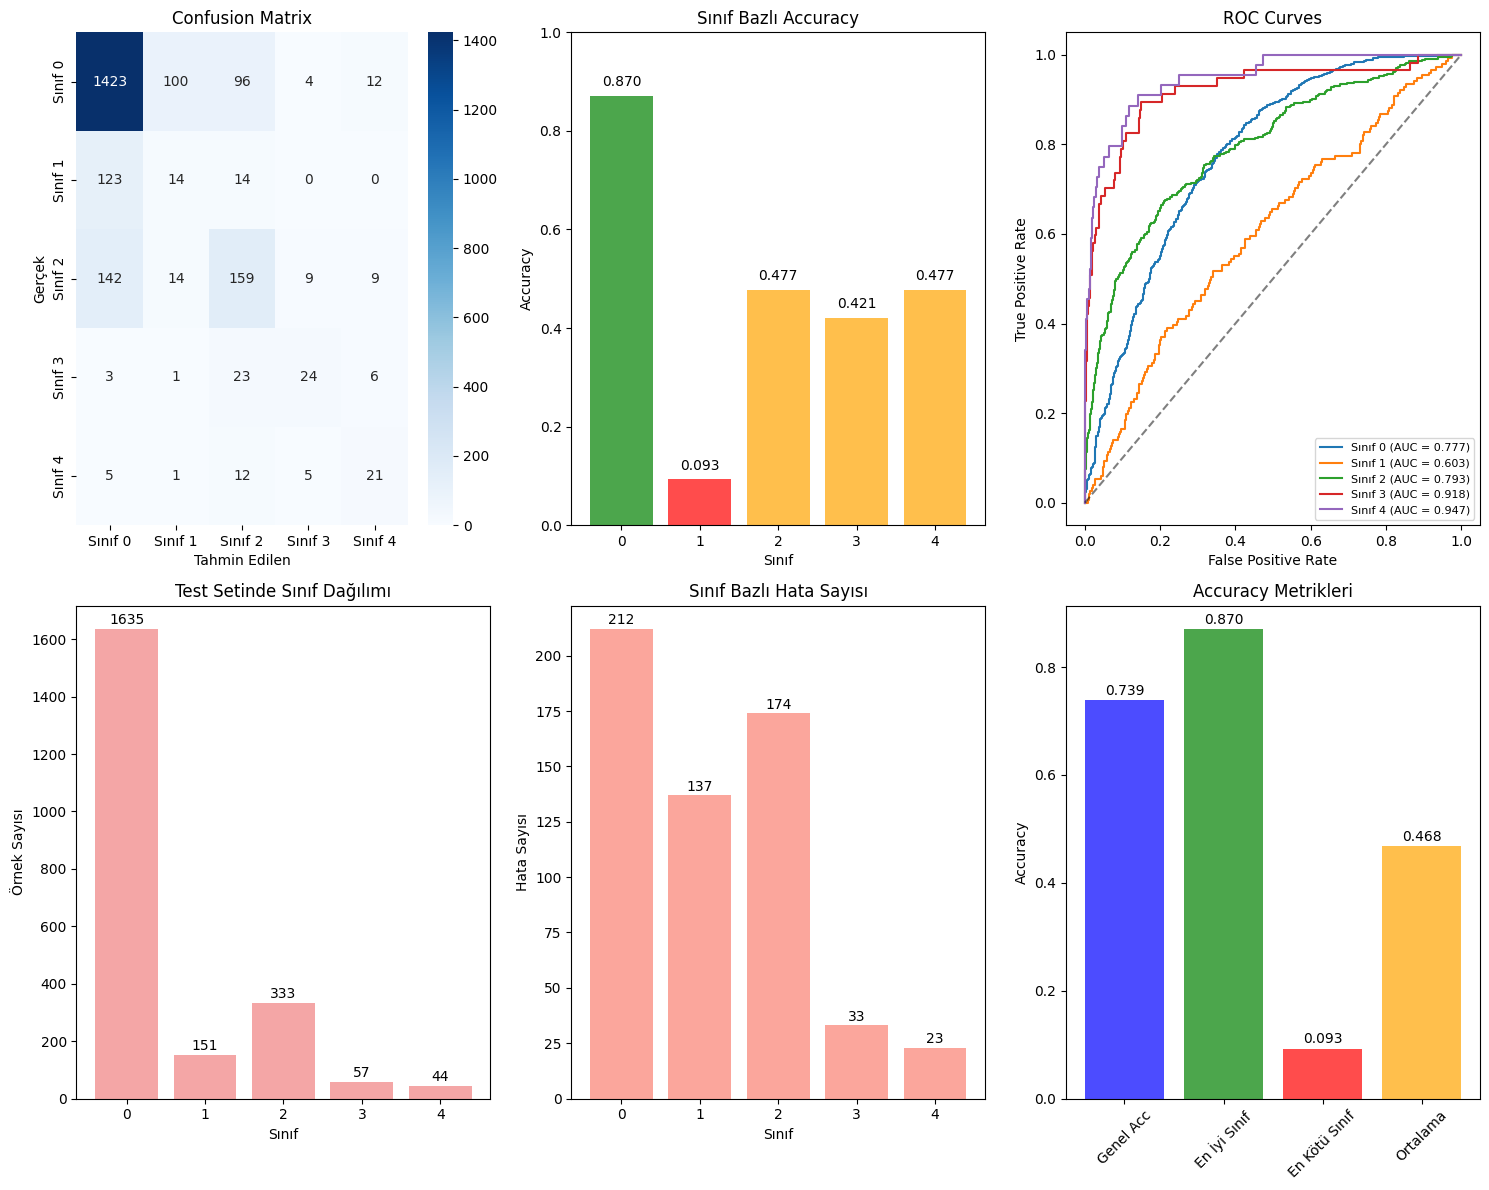


📋 DETAYLI CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Sınıf 0     0.8390    0.8703    0.8544      1635
     Sınıf 1     0.1077    0.0927    0.0996       151
     Sınıf 2     0.5230    0.4775    0.4992       333
     Sınıf 3     0.5714    0.4211    0.4848        57
     Sınıf 4     0.4375    0.4773    0.4565        44

    accuracy                         0.7392      2220
   macro avg     0.4957    0.4678    0.4789      2220
weighted avg     0.7271    0.7392    0.7324      2220

💾 Test sonuçları CSV'ye kaydedildi: /content/drive/MyDrive/Colab Notebooks/test_results/worker_safe_test_results_20250525_183023.csv

📊 ÖZET İSTATİSTİKLER:
🎯 Genel Accuracy: 0.7392
📈 En iyi sınıf accuracy: 0.8703 (Sınıf 0)
📉 En kötü sınıf accuracy: 0.0927 (Sınıf 1)
📊 Ortalama sınıf accuracy: 0.4678
📏 Standart sapma: 0.2470

🔍 HATA ANALİZİ:
❌ Toplam hata: 579/2220
📊 Hata oranı: 26.08%

🔄 EN ÇOK KARIŞTIRILAN SINIFLAR:
  Sınıf 1 → Sınıf 0: 123 hata (81.5%)
  Sınıf 2 → Sınıf 0

In [ ]:
# Hücre: WORKER-SAFE MODEL TEST VE DEĞERLENDİRME
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import os
from datetime import datetime
from torch.utils.data import DataLoader

print("🧪 WORKER-SAFE MODEL TEST VE DEĞERLENDİRME")
print("=" * 60)

try:
    # Gerekli değişkenlerin kontrolü
    required_vars = ['model', 'test_dataset', 'device', 'num_classes']
    for var in required_vars:
        if var not in locals() and var not in globals():
            raise NameError(f"'{var}' değişkeni tanımlı değil.")

    print("🔧 Worker-safe DataLoader oluşturuluyor...")

    # WORKER-SAFE TEST DATALOADER
    test_loader_safe = DataLoader(
        test_dataset,
        batch_size=32,  # Güvenli batch size
        shuffle=False,  # Test için shuffle gerekmez
        num_workers=0,  # WORKER SORUNU ÇÖZÜMLERİ
        pin_memory=False,  # Colab için güvenli
        persistent_workers=False,  # Worker sorunları için
        drop_last=False  # Tüm test verilerini kullan
    )

    print("✅ Worker-safe test DataLoader oluşturuldu")
    print(f"📊 Test dataset: {len(test_dataset)} örnek")
    print(f"📦 Batch size: {test_loader_safe.batch_size}")
    print(f"👥 Workers: {test_loader_safe.num_workers}")

    # Test sonuçları için klasör oluştur
    test_results_dir = "/content/drive/MyDrive/Colab Notebooks/test_results"
    os.makedirs(test_results_dir, exist_ok=True)

    # Zaman damgası
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    print(f"📁 Sonuçlar kaydedilecek: {test_results_dir}")

    # Model test moduna al
    model.eval()

    # Test değişkenleri
    all_predictions = []
    all_true_labels = []
    all_probabilities = []
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    total_correct = 0
    total_samples = 0

    print("\n🔍 WORKER-SAFE test verisi üzerinde tahmin yapılıyor...")

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader_safe):
            try:
                # Geçersiz etiketleri filtrele
                valid_indices = (labels != -1)
                if not valid_indices.any():
                    print(f"    ⚠️ Batch {batch_idx}: Geçersiz etiketler atlandı")
                    continue

                inputs = inputs[valid_indices].to(device, non_blocking=True)
                labels = labels[valid_indices].to(device, non_blocking=True)

                # Tahmin yap
                outputs = model(inputs)
                probabilities = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                # Sonuçları kaydet
                all_predictions.extend(predicted.cpu().numpy())
                all_true_labels.extend(labels.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

                # Genel accuracy hesapla
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                # Sınıf bazlı accuracy hesapla
                for i in range(labels.size(0)):
                    label = labels[i].item()
                    if 0 <= label < num_classes:  # Geçerli sınıf kontrolü
                        class_total[label] += 1
                        if predicted[i] == label:
                            class_correct[label] += 1

                # İlerleme raporu (her 15 batch'te)
                if (batch_idx + 1) % 15 == 0:
                    current_acc = total_correct / total_samples if total_samples > 0 else 0
                    gpu_mem = torch.cuda.memory_allocated() / 1024**3 if device.type == 'cuda' else 0
                    print(f"    ✅ Batch {batch_idx+1}/{len(test_loader_safe)}: "
                          f"Acc: {current_acc:.4f}, "
                          f"Samples: {total_samples}, "
                          f"GPU: {gpu_mem:.1f}GB")

            except Exception as batch_error:
                print(f"    ❌ Batch {batch_idx} hatası: {str(batch_error)}")
                continue

    # Sonuçları kontrol et
    if len(all_true_labels) == 0:
        print("❌ Hiç geçerli test verisi bulunamadı!")
        raise ValueError("Test verisi boş")

    # NumPy array'lere çevir
    y_true = np.array(all_true_labels)
    y_pred = np.array(all_predictions)
    y_prob = np.array(all_probabilities)

    # Genel test accuracy
    test_accuracy = total_correct / total_samples if total_samples > 0 else 0

    print(f"\n🎯 WORKER-SAFE TEST SONUÇLARI:")
    print("=" * 45)
    print(f"📊 Genel Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"📈 İşlenen toplam örnek: {total_samples}")
    print(f"✅ Doğru tahmin: {total_correct}")

    # Sınıf bazlı accuracy
    print(f"\n📈 Sınıf Bazlı Accuracies:")
    class_accuracies = []
    for i in range(num_classes):
        if class_total[i] > 0:
            class_acc = class_correct[i] / class_total[i]
            class_accuracies.append(class_acc)
            print(f"  Sınıf {i}: {class_acc:.4f} ({class_acc*100:.1f}%) - {class_total[i]} örnek")
        else:
            class_accuracies.append(0.0)
            print(f"  Sınıf {i}: 0.0000 (0.0%) - 0 örnek")

    # Confusion Matrix
    print(f"\n📊 Confusion Matrix oluşturuluyor...")
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 12))

    # Confusion Matrix grafiği
    plt.subplot(2, 3, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Sınıf {i}' for i in range(num_classes)],
                yticklabels=[f'Sınıf {i}' for i in range(num_classes)])
    plt.title('Confusion Matrix')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')

    # Sınıf bazlı accuracy bar grafiği
    plt.subplot(2, 3, 2)
    colors = ['red' if acc < 0.3 else 'orange' if acc < 0.6 else 'green' for acc in class_accuracies]
    plt.bar(range(num_classes), class_accuracies, color=colors, alpha=0.7)
    plt.xlabel('Sınıf')
    plt.ylabel('Accuracy')
    plt.title('Sınıf Bazlı Accuracy')
    plt.xticks(range(num_classes))
    plt.ylim(0, 1)
    for i, acc in enumerate(class_accuracies):
        plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=10)

    # ROC Curve (çok sınıflı)
    plt.subplot(2, 3, 3)
    if len(np.unique(y_true)) > 1:  # En az 2 sınıf varsa
        try:
            y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

            # Her sınıf için ROC eğrisi
            for i in range(min(num_classes, y_prob.shape[1])):
                if i < y_true_bin.shape[1]:
                    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f'Sınıf {i} (AUC = {roc_auc:.3f})')

            plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curves')
            plt.legend(fontsize=8)
        except Exception as roc_error:
            plt.text(0.5, 0.5, f'ROC hesaplanamadı:\n{str(roc_error)}',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('ROC Curves (Hata)')
    else:
        plt.text(0.5, 0.5, 'ROC için yeterli sınıf yok',
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('ROC Curves (Yetersiz Veri)')

    # Sınıf dağılımı
    plt.subplot(2, 3, 4)
    unique, counts = np.unique(y_true, return_counts=True)
    plt.bar(unique, counts, color='lightcoral', alpha=0.7)
    plt.xlabel('Sınıf')
    plt.ylabel('Örnek Sayısı')
    plt.title('Test Setinde Sınıf Dağılımı')
    plt.xticks(unique)
    for i, count in zip(unique, counts):
        plt.text(i, count + max(counts)*0.01, str(count), ha='center')

    # Hata dağılımı
    plt.subplot(2, 3, 5)
    errors_per_class = [class_total[i] - class_correct[i] for i in range(num_classes)]
    plt.bar(range(num_classes), errors_per_class, color='salmon', alpha=0.7)
    plt.xlabel('Sınıf')
    plt.ylabel('Hata Sayısı')
    plt.title('Sınıf Bazlı Hata Sayısı')
    plt.xticks(range(num_classes))
    for i, error in enumerate(errors_per_class):
        if error > 0:
            plt.text(i, error + max(errors_per_class)*0.01, str(error), ha='center')

    # Accuracy karşılaştırması
    plt.subplot(2, 3, 6)
    metrics = ['Genel Acc', 'En İyi Sınıf', 'En Kötü Sınıf', 'Ortalama']
    values = [
        test_accuracy,
        max(class_accuracies) if class_accuracies else 0,
        min(class_accuracies) if class_accuracies else 0,
        np.mean(class_accuracies) if class_accuracies else 0
    ]
    plt.bar(metrics, values, color=['blue', 'green', 'red', 'orange'], alpha=0.7)
    plt.ylabel('Accuracy')
    plt.title('Accuracy Metrikleri')
    plt.xticks(rotation=45)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()

    # Grafikleri kaydet
    plot_path = os.path.join(test_results_dir, f"worker_safe_test_analysis_{timestamp}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"📈 Test analiz grafiği kaydedildi: {plot_path}")
    plt.show()

    # Detaylı classification report
    print(f"\n📋 DETAYLI CLASSIFICATION REPORT:")
    print("=" * 50)
    try:
        class_names = [f'Sınıf {i}' for i in range(num_classes)]
        report = classification_report(y_true, y_pred,
                                     target_names=class_names,
                                     digits=4,
                                     zero_division=0)
        print(report)
    except Exception as report_error:
        print(f"Classification report hatası: {str(report_error)}")

    # Sonuçları CSV'ye kaydet
    results_df = pd.DataFrame({
        'Sınıf': range(num_classes),
        'Accuracy': class_accuracies,
        'Toplam_Örnek': [class_total[i] for i in range(num_classes)],
        'Doğru_Tahmin': [class_correct[i] for i in range(num_classes)],
        'Hata_Sayısı': [class_total[i] - class_correct[i] for i in range(num_classes)]
    })

    csv_path = os.path.join(test_results_dir, f"worker_safe_test_results_{timestamp}.csv")
    results_df.to_csv(csv_path, index=False)
    print(f"💾 Test sonuçları CSV'ye kaydedildi: {csv_path}")

    # Özet istatistikler
    print(f"\n📊 ÖZET İSTATİSTİKLER:")
    print("=" * 30)
    print(f"🎯 Genel Accuracy: {test_accuracy:.4f}")
    if class_accuracies:
        print(f"📈 En iyi sınıf accuracy: {max(class_accuracies):.4f} (Sınıf {np.argmax(class_accuracies)})")
        print(f"📉 En kötü sınıf accuracy: {min(class_accuracies):.4f} (Sınıf {np.argmin(class_accuracies)})")
        print(f"📊 Ortalama sınıf accuracy: {np.mean(class_accuracies):.4f}")
        print(f"📏 Standart sapma: {np.std(class_accuracies):.4f}")

    # Hata analizi
    print(f"\n🔍 HATA ANALİZİ:")
    print("=" * 20)
    total_errors = total_samples - total_correct
    print(f"❌ Toplam hata: {total_errors}/{total_samples}")
    print(f"📊 Hata oranı: {(total_errors/total_samples)*100:.2f}%")

    # En çok karıştırılan sınıflar
    print(f"\n🔄 EN ÇOK KARIŞTIRILAN SINIFLAR:")
    print("=" * 35)
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                total_class_i = np.sum(cm[i, :])
                if total_class_i > 0:
                    error_rate = cm[i, j] / total_class_i * 100
                    if error_rate > 10:  # %10'dan fazla karıştırma
                        print(f"  Sınıf {i} → Sınıf {j}: {cm[i, j]} hata ({error_rate:.1f}%)")

    print(f"\n✅ WORKER-SAFE test analizi tamamlandı!")
    print(f"📁 Tüm sonuçlar şu klasöre kaydedildi: {test_results_dir}")
    print(f"🔧 Worker sorunları çözüldü (workers=0)")

except Exception as e:
    print(f"❌ Test sırasında hata: {str(e)}")
    import traceback
    traceback.print_exc()

    # Alternatif basit test
    print(f"\n🔄 Alternatif basit test deneniyor...")
    try:
        model.eval()
        sample_correct = 0
        sample_total = 0

        # Tek tek batch işle
        for i in range(min(10, len(test_dataset))):
            try:
                sample_data = test_dataset[i]
                if len(sample_data) == 2:
                    input_tensor, label = sample_data
                    if label != -1:  # Geçerli etiket
                        input_tensor = input_tensor.unsqueeze(0).to(device)
                        with torch.no_grad():
                            output = model(input_tensor)
                            _, predicted = torch.max(output, 1)
                            sample_total += 1
                            if predicted.item() == label:
                                sample_correct += 1
            except:
                continue

        if sample_total > 0:
            sample_acc = sample_correct / sample_total
            print(f"🎯 Basit test sonucu: {sample_acc:.4f} ({sample_total} örnek)")
        else:
            print("❌ Basit test de başarısız")

    except Exception as simple_error:
        print(f"❌ Basit test hatası: {str(simple_error)}")